### 1. Construct GHZ circuit(W state also) and run on hardware, apply readout error mitigation <br>
<br>

#### I. Active, Passive readout error mitigation 
#### <br>II. M3(TREX) method with IBM runtime 

In [10]:
# Importing provider and getting access to the system
from qiskit_ibm_provider import IBMProvider
from qiskit import transpile


provider = IBMProvider(instance = 'q-info-hackathon/team-6/main')

backend = provider.get_backend("ibm_canberra")

config = backend.configuration()
ly = config.coupling_map

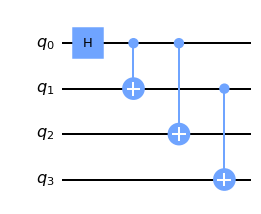

In [24]:
# GHZ
import qiskit
from qiskit import QuantumCircuit
import numpy as np

def ghz_4(layouts):
    circ = QuantumCircuit(4,4)
    circ.h(layouts[0])
    circ.cx(layouts[0], layouts[1])
    circ.cx(layouts[0], layouts[2])
    circ.cx(layouts[1], layouts[3])
    return circ
def ghz_4_ac(layouts, ancila):
    
    circ = QuantumCircuit(len(layouts)+len(ancila))
    circ.h(layouts[0])
    circ.cx(layouts[0], layouts[1])
    circ.cx(layouts[0], layouts[2])
    circ.cx(layouts[1], layouts[3])
    
    circ.cx(layouts[0], ancila[0])
    circ.cx(layouts[1], ancila[1])

    circ.cx(layouts[3], ancila[2])
    
    circ.measure_all()
    
    return circ
def CG(p,qubits):
    theta = np.arcsin(np.sqrt(p))
    circ = QuantumCircuit(4)
    circ.u(theta,0,0,qubits[1])
    circ.cx(qubits[0],qubits[1])
    circ.u(-theta,0,0, qubits[1])
    return circ

def W_4(layouts):
    circ = QuantumCircuit(4)
    circ.x(layouts[0])
    circ = circ.compose(CG(1/4, qubits = [0,1]))
    circ.cx(layouts[1], layouts[0])
    circ = circ.compose(CG(1/3, qubits = [1,2]))
    circ.cx(layouts[2], layouts[1])
    circ = circ.compose(CG(1/2, qubits = [2,3]))
    circ.cx(layouts[3], layouts[2])
    return circ

def ghz_3(layouts):
    circ = QuantumCircuit(3,3)
    circ.h(layouts[0])
    circ.cx(layouts[0],layouts[1])
    circ.cx(layouts[1],layouts[2])
    return circ

ghz4 = ghz_4([0,1,2,3])
ghz4.draw('mpl', idle_wires=False)

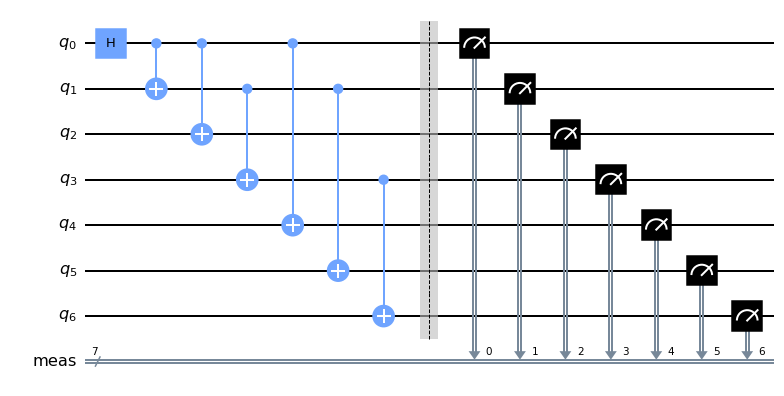

In [25]:
ghz4_ac = ghz_4_ac([0,1,2,3],[4,5,6])
ghz4_ac.draw('mpl')

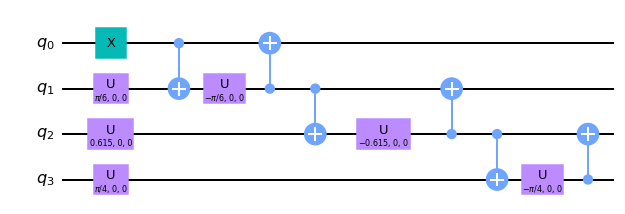

In [ ]:
w4 = W_4([0,1,2,3])
w4.draw('mpl')

In [ ]:
# Run W state on ibm_canberra without readout error mitigation
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()

hub = "q-info-hackathon"
group = "team-6"
project = "main"

backend_name = "ibm_canberra"
backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")

qc = QuantumCircuit(4, 4)
qc = qc.compose(w4)
qc.measure([0, 1, 2, 3], [0, 1, 2, 3])

stc1 = transpile(qc, backend, initial_layout = best1[:4])
job = backend.run(stc1, shots=20000)
job_id = job.job_id()
print(job_id)

ci9vqv9g5luj4cja3apg


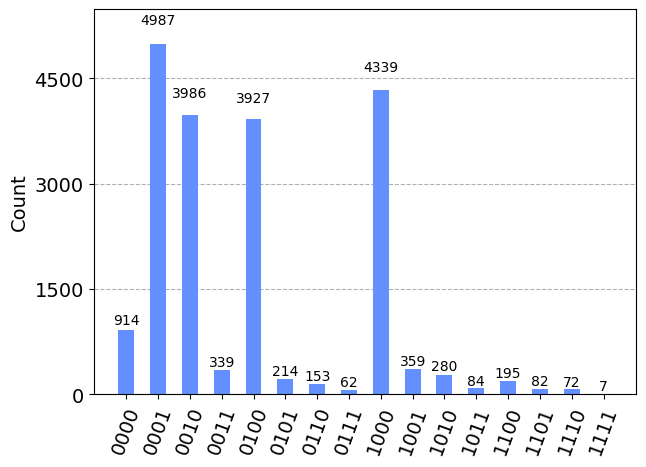

In [ ]:
from qiskit.visualization import plot_histogram
retrieve_job = provider.retrieve_job(job.job_id())
retrieve_job.status()

exp_result = retrieve_job.result()
exp_counts = exp_result.get_counts()

plot_histogram(exp_counts)

## How to choose and quatify the performance of sets of qubits considering ancilla qubits

### Step
##### 1. Find possible 4 qubits sets
##### 2. Find the ones have qubits which is connected to 3 adjacent qubits from above sets
##### 3. Discard repetitive sets
##### 4. Calculate effective errors(two qubit repetition code) and sort to find best 2 sets and worst 2 sets

In [ ]:
# find connections
connection = {}

for babies in ly:
    if str(babies[0]) in connection.keys():
        temp = list(connection[str(babies[0])])
        temp.append(str(babies[1]))
        connection[str(babies[0])] = temp
    else:
        connection[str(babies[0])] = [str(babies[1])]

print(connection)

In [ ]:
# Find possible qubit sets, good_4qubit

num_qubit = 27
list_4qubit = []
for index in range(num_qubit - 1):
    temp_list = [index]
    if str(index) in connection.keys():
        for new_index in connection[str(index)]:
            tempvar1 = int(new_index)
            if new_index in connection.keys():
                for next_index in connection[new_index]:
                    tempvar2 = int(next_index)
                    if next_index in connection.keys():
                        for final_index in connection[next_index]:
                            tempvar3 = int(final_index)
                            temp_list = [index, int(new_index), int(next_index), int(final_index)]
                            if len(temp_list) == 4:
                                list_4qubit.append(temp_list)
good_4qubit = []

for obj in list_4qubit:
    a1 = obj[0]
    a2 = obj[1]
    a3 = obj[2]
    a4 = obj[3]
    if a1 != a2 and a1 != a3 and a1 != a4 and a2 != a3 and a2 != a4 and a3 != a4:
        good_4qubit.append(obj)

In [ ]:
# get qubit properties, prob_meas0_prep1, prob_meas1_prep0, readout error, cx error

prop = backend.properties()
readout_error = []
for i in range(num_qubit):
    readout_error.append(prop.qubit_property(i, 'readout_error')[0])

q = []
for i in range(num_qubit):
    q.append(0.5*(prop.qubit_property(i, 'prob_meas0_prep1')[0] + prop.qubit_property(i, 'prob_meas1_prep0')[0]))

eps = np.zeros([num_qubit,num_qubit])
for [a, b] in ly:
    eps[a, b] = prop.gate_error('cx', [a, b])

In [ ]:
# Calculate effective error

def two_qubit(a, b):
    return eps[a, b]/4 + q[a]**2

def three_qubit(a, b, c):
    return 3*(np.maximum(eps[a, b], eps[a, c])/4 + q[a]**2)

In [ ]:
# Get amazing_4qubit

very_good_4qubit = []
for qubitset in good_4qubit:
    externalcount = 0
    for element in qubitset:
        tempcount = 0
        for connectedQ in connection[str(element)]:
            if int(connectedQ) not in qubitset:
                tempcount = tempcount + 1
        if tempcount > 0:
            externalcount = externalcount + 1


    if externalcount == 3:
        very_good_4qubit.append(qubitset)

amazing_4qubit = []
for amazing in very_good_4qubit:
    amazing.sort()
    if amazing not in amazing_4qubit:
        amazing_4qubit.append(amazing)


In [ ]:
amazing_4qubit

[[1, 4, 7, 10],
 [1, 2, 4, 7],
 [1, 2, 3, 4],
 [3, 5, 8, 11],
 [4, 7, 10, 12],
 [5, 8, 11, 14],
 [7, 10, 12, 13],
 [7, 10, 12, 15],
 [8, 11, 13, 14],
 [8, 11, 14, 16],
 [10, 12, 13, 14],
 [10, 12, 15, 18],
 [11, 12, 13, 14],
 [11, 14, 16, 19],
 [12, 13, 14, 16],
 [12, 15, 18, 21],
 [12, 13, 15, 18],
 [13, 14, 16, 19],
 [12, 13, 14, 15],
 [14, 16, 19, 22],
 [15, 18, 21, 23],
 [16, 19, 22, 25],
 [19, 22, 24, 25],
 [22, 23, 24, 25]]

In [ ]:
# Quantize the performance of qubit sets
theindex = []
probabilities = []
for fq in amazing_4qubit:
    goodpairs = []
    bad_qubit = 0
    for elem in fq:
        safe = False
        for connectedQ in connection[str(elem)]:
            if int(connectedQ) not in fq:
                safe = True
                goodpairs.append([elem, int(connectedQ)])
            if safe is False:
                bad_qubit = int(connectedQ)
    #print(goodpairs)

    if len(goodpairs) == 4:
        standard = [0, 1, 2, 3]
        removal = 0
        for i in range(len(goodpairs) - 1):
            if goodpairs[i][0] == goodpairs[i+1][0]:
                p1 = two_qubit(goodpairs[i][0], goodpairs[i][1])
                p2 = two_qubit(goodpairs[i+1][0], goodpairs[i+1][1])
                if p1 > p2:
                    removal = i
                else:
                    removal = i+1
        standard.pop(removal)
        hahaha = []
        for j in range(3):
            hahaha.append(goodpairs[standard[j]])
        theindex.append(hahaha)

    else:
        theindex.append(goodpairs)


    p_correct = (1 - readout_error[bad_qubit])
    for things in theindex[-1]:
        if things[0] != bad_qubit:
            p_correct = p_correct * (1 - two_qubit(things[0], things[1]))
    probabilities.append(p_correct)

In [ ]:
# This performance values depend on calibration of IBM which changes everyday
prob_array = [[x, y] for x, y in zip(probabilities, amazing_4qubit)]
sorted(prob_array)

[[0.7101795149797284, [15, 18, 21, 23]],
 [0.9211295107767663, [1, 2, 4, 7]],
 [0.9334404942956175, [22, 23, 24, 25]],
 [0.9373700099975102, [19, 22, 24, 25]],
 [0.9478085901001727, [7, 10, 12, 15]],
 [0.9479723635803164, [5, 8, 11, 14]],
 [0.9480160560790225, [7, 10, 12, 13]],
 [0.9502487309366804, [11, 14, 16, 19]],
 [0.9506613203193462, [13, 14, 16, 19]],
 [0.951626455094902, [12, 13, 14, 15]],
 [0.9532287676512312, [1, 4, 7, 10]],
 [0.95455368823144, [4, 7, 10, 12]],
 [0.9592733452157228, [14, 16, 19, 22]],
 [0.9667088227140149, [1, 2, 3, 4]],
 [0.9690453653527326, [12, 13, 14, 16]],
 [0.9691544876849959, [16, 19, 22, 25]],
 [0.9705736050821081, [10, 12, 13, 14]],
 [0.9707075355230773, [8, 11, 14, 16]],
 [0.970788798420706, [11, 12, 13, 14]],
 [0.9754935406708112, [12, 15, 18, 21]],
 [0.9758126844009003, [10, 12, 15, 18]],
 [0.9778210520288816, [8, 11, 13, 14]],
 [0.97812598828705, [12, 13, 15, 18]],
 [0.9831852999039822, [3, 5, 8, 11]]]

In [249]:
# Response matrix of 4 qubit, 16x16 matrix, considering only the local error on each qubit
def resp_matrix(backend, qubits):
    qubits = qubits[0:4]
    props = backend.properties()
    matrix_list = []
    for i in range(len(qubits)):
        prob_meas0_prep1 = list(props.qubit_property(qubits[i]).values())[5][0]
        prob_meas1_prep0 = list(props.qubit_property(qubits[i]).values())[6][0]
        matrix = [
            [1 - prob_meas1_prep0, prob_meas0_prep1],
            [prob_meas1_prep0, 1 - prob_meas0_prep1],
        ]
        matrix_list.append(matrix)
    tensor_prod1 = np.kron(matrix_list[0],matrix_list[1])
    tensor_prod2 = np.kron(matrix_list[2],matrix_list[3])
    tensor_prod = np.kron(tensor_prod1,tensor_prod2)
    return np.linalg.inv(tensor_prod)

# Active readout error mitigation scheme, discard the shot results which have '01' or '10' bits from the qubit and the connected ancilla qubits
# We only used two qubit repetition scheme, since three qubit repetition's effective error rate is similar to just readout error
def detect_discard(counts,couple):
    res_list = list(counts.keys())
    right = []
    for i in range(len(res_list)):
        count = 0
        for j in range(len(couple)):
            if (int(res_list[i][couple[j][0]]) + int(res_list[i][couple[j][1]])) == 1:
                count += 1
        if count == 0:
            right.append(i)

    keys, vals = [], []
    for i in range(len(right)):
        keys.append(list(counts.keys())[right[i]])
        vals.append(list(counts.values())[right[i]])
    mitigated = dict(zip(keys,vals))
    
    return mitigated

# Truncate 7 qubit results into 4 qubit results to see only the 4 qubits other than ancilla qubits
def truncate(counts,state_labels):
    trunc_counts = {bits : 0 for bits in state_labels}
    for i in range(len(counts)):
        bits = list(counts)[i][0:4]
        trunc_counts[bits] += list(counts.values())[i]
    return trunc_counts

# Convert function which converts Counts dictionary into matrix 
def counts_to_sv(counts):
    sv = np.zeros(2**4)
    total = sum(counts.values())
    probs = {state: count / total for state, count in counts.items()}
    for state, probability in probs.items():
        index = int(state, 2)
        sv[index] = probability
    return sv

def sv_to_counts(sv):
    
    counts = {bin(i)[2:].zfill(int(np.log2(len(sv)))): int(prob*20000) for i, prob in enumerate(sv)}
    return counts

# exact probability matrix, not state vector, it's probability
exact_state = np.zeros(16)
exact_state[0], exact_state[-1] = 1/2, 1/2

# We choosed two of best qubit sets and worst qubit sets each with respective ancilla qubits from ibm_canberra
# Couples are the coupling_map for the selected qubits and ancilla qubits
from qiskit import transpile

best1 = [3,5,8,11, 2, 9, 14]
best2 = [13,12,15,18, 14,10,17]
worst1 = [23,24,25,22, 21, 26, 19]
worst2 = [15,18,21,23, 12,17,24]
circuit_list = [best1, best2, worst1, worst2]
coupleb1 = [[3,2], [8,9], [11,14]] 
coupleb2 = [[13,14], [12,10], [18,17]]
couplew1 = [[23,21], [25,26], [22,19]]
couplew2 = [[15,12], [18,17], [23,24]]

# Transpile those circuits with respective layouts
tcb1 = transpile(ghz4_ac, backend = backend, initial_layout = best1)
tcb2 = transpile(ghz4_ac, backend = backend, initial_layout = best2)
tcw1 = transpile(ghz4_ac, backend = backend, initial_layout = worst1)
tcw2 = transpile(ghz4_ac, backend = backend, initial_layout = worst2)

In [ ]:
# Run and get result
job = backend.run([tcb1,tcb2,tcw1,tcw2]*4, shots = 20000)
res = [[job.result().get_counts()[4*i + j] for i in range(4)] for j in range(4)]

Below are the results of ghz 4 qubit states from real hardware, ibm_canberra, job id is 'ci9sl7902cefj73bpdtg'
<br/>
We ran each circuits 4 times to reduce error

In [233]:
counts_result = [[{'0000000': 7304, '0000001': 233, '0010000': 542, '0010001': 210, '0010010': 10, '0010011': 25, '0010100': 29, '0010101': 327, '0010110': 4, '0010111': 28, '0011000': 14, '0011001': 9, '0011010': 3, '0011011': 4, '0011101': 20, '0011110': 1, '0011111': 9, '0000010': 50, '0100000': 148, '0100001': 10, '0100010': 65, '0100011': 3, '0100100': 17, '0100101': 5, '0100110': 21, '0100111': 5, '0101000': 11, '0101001': 1, '0101010': 32, '0101011': 2, '0101100': 3, '0101101': 1, '0101110': 10, '0101111': 8, '0000011': 3, '0110000': 7, '0110001': 23, '0110010': 7, '0110011': 26, '0110100': 2, '0110101': 37, '0110110': 1, '0110111': 163, '0111000': 1, '0111001': 4, '0111010': 1, '0111011': 14, '0111100': 1, '0111101': 8, '0111110': 4, '0111111': 297, '0000100': 307, '1000000': 122, '1000001': 2, '1000010': 3, '1000100': 6, '1000110': 5, '1001000': 118, '1001001': 7, '1001010': 58, '1001011': 4, '1001100': 22, '1001101': 3, '1001110': 34, '1001111': 8, '0000101': 43, '1010000': 10, '1010001': 7, '1010010': 1, '1010011': 4, '1010100': 2, '1010101': 11, '1010110': 2, '1010111': 14, '1011000': 13, '1011001': 26, '1011010': 6, '1011011': 30, '1011100': 5, '1011101': 86, '1011110': 7, '1011111': 186, '0000110': 24, '1100000': 6, '1100010': 22, '1100011': 2, '1100100': 3, '1100110': 14, '1100111': 9, '1101000': 37, '1101001': 1, '1101010': 479, '1101011': 46, '1101100': 21, '1101101': 6, '1101110': 173, '1101111': 229, '0000111': 1, '1110001': 2, '1110010': 3, '1110011': 15, '1110100': 1, '1110101': 5, '1110110': 4, '1110111': 279, '1111000': 2, '1111001': 18, '1111010': 39, '1111011': 336, '1111100': 3, '1111101': 141, '1111110': 63, '1111111': 6819, '0001000': 249, '0001001': 7, '0001010': 9, '0001011': 1, '0001100': 11, '0001101': 4, '0001110': 1}, {'0000000': 7305, '0000001': 205, '0010000': 589, '0010001': 187, '0010010': 6, '0010011': 17, '0010100': 29, '0010101': 302, '0010110': 6, '0010111': 37, '0011000': 18, '0011001': 8, '0011010': 1, '0011011': 2, '0011100': 1, '0011101': 16, '0011111': 14, '0000010': 62, '0100000': 156, '0100001': 9, '0100010': 59, '0100011': 5, '0100100': 28, '0100101': 1, '0100110': 22, '0100111': 6, '0101000': 9, '0101010': 30, '0101011': 2, '0101100': 2, '0101110': 19, '0101111': 12, '0000011': 3, '0110000': 15, '0110001': 23, '0110010': 3, '0110011': 36, '0110100': 4, '0110101': 27, '0110110': 8, '0110111': 174, '0111001': 3, '0111010': 1, '0111011': 19, '0111100': 1, '0111101': 12, '0111110': 4, '0111111': 280, '0000100': 310, '1000000': 142, '1000001': 2, '1000010': 4, '1000011': 1, '1000100': 6, '1000101': 2, '1000110': 1, '1000111': 2, '1001000': 135, '1001001': 3, '1001010': 50, '1001011': 7, '1001100': 19, '1001101': 7, '1001110': 38, '1001111': 6, '0000101': 65, '1010000': 7, '1010001': 3, '1010011': 4, '1010100': 1, '1010101': 12, '1010111': 9, '1011000': 11, '1011001': 19, '1011010': 7, '1011011': 47, '1011100': 3, '1011101': 79, '1011110': 8, '1011111': 202, '0000110': 33, '1100000': 3, '1100010': 22, '1100011': 4, '1100100': 3, '1100101': 1, '1100110': 9, '1100111': 13, '1101000': 34, '1101001': 5, '1101010': 467, '1101011': 43, '1101100': 11, '1101101': 5, '1101110': 137, '1101111': 215, '0000111': 2, '1110001': 2, '1110010': 2, '1110011': 12, '1110100': 1, '1110101': 11, '1110110': 5, '1110111': 346, '1111000': 3, '1111001': 22, '1111010': 51, '1111011': 347, '1111100': 2, '1111101': 131, '1111110': 58, '1111111': 6753, '0001000': 221, '0001001': 11, '0001010': 8, '0001100': 11, '0001101': 1, '0001110': 5}, {'0000000': 7305, '0000001': 217, '0010000': 551, '0010001': 218, '0010010': 4, '0010011': 22, '0010100': 29, '0010101': 301, '0010110': 4, '0010111': 29, '0011000': 21, '0011001': 8, '0011011': 3, '0011100': 1, '0011101': 15, '0011110': 1, '0011111': 9, '0000010': 53, '0100000': 132, '0100001': 8, '0100010': 49, '0100011': 5, '0100100': 28, '0100101': 4, '0100110': 28, '0100111': 3, '0101000': 4, '0101001': 3, '0101010': 30, '0101100': 1, '0101110': 10, '0101111': 12, '0000011': 5, '0110000': 9, '0110001': 23, '0110010': 5, '0110011': 34, '0110100': 3, '0110101': 41, '0110110': 5, '0110111': 140, '0111000': 1, '0111001': 2, '0111010': 1, '0111011': 19, '0111101': 17, '0111110': 3, '0111111': 318, '0000100': 318, '1000000': 144, '1000001': 4, '1000010': 4, '1000011': 1, '1000100': 7, '1000101': 3, '1000110': 3, '1001000': 135, '1001001': 1, '1001010': 48, '1001011': 3, '1001100': 24, '1001101': 6, '1001110': 47, '1001111': 11, '0000101': 47, '1010000': 7, '1010001': 3, '1010011': 5, '1010100': 1, '1010101': 9, '1010110': 1, '1010111': 12, '1011000': 5, '1011001': 26, '1011010': 7, '1011011': 45, '1011100': 4, '1011101': 97, '1011110': 9, '1011111': 203, '0000110': 27, '1100000': 2, '1100001': 1, '1100010': 30, '1100100': 2, '1100101': 1, '1100110': 12, '1100111': 7, '1101000': 23, '1101001': 4, '1101010': 509, '1101011': 35, '1101100': 18, '1101101': 7, '1101110': 149, '1101111': 246, '0000111': 4, '1110001': 1, '1110010': 1, '1110011': 19, '1110101': 9, '1110110': 1, '1110111': 332, '1111000': 5, '1111001': 29, '1111010': 47, '1111011': 336, '1111101': 129, '1111110': 59, '1111111': 6709, '0001000': 244, '0001001': 4, '0001010': 7, '0001100': 10, '0001110': 7}, {'0000000': 7272, '0000001': 214, '0010000': 588, '0010001': 213, '0010010': 4, '0010011': 28, '0010100': 24, '0010101': 278, '0010110': 4, '0010111': 34, '0011000': 28, '0011001': 10, '0011010': 1, '0011011': 2, '0011100': 1, '0011101': 13, '0011110': 2, '0011111': 15, '0000010': 50, '0100000': 138, '0100001': 7, '0100010': 69, '0100011': 1, '0100100': 30, '0100101': 2, '0100110': 25, '0100111': 4, '0101000': 4, '0101001': 1, '0101010': 25, '0101011': 2, '0101100': 6, '0101110': 9, '0101111': 6, '0000011': 5, '0110000': 15, '0110001': 22, '0110010': 10, '0110011': 24, '0110100': 2, '0110101': 34, '0110110': 2, '0110111': 172, '0111000': 1, '0111001': 1, '0111010': 1, '0111011': 19, '0111101': 9, '0111110': 7, '0111111': 285, '0000100': 308, '1000000': 112, '1000001': 3, '1000010': 2, '1000100': 3, '1000110': 3, '1001000': 126, '1001001': 6, '1001010': 68, '1001011': 7, '1001100': 25, '1001101': 7, '1001110': 34, '1001111': 12, '0000101': 40, '1010000': 9, '1010001': 8, '1010011': 1, '1010100': 2, '1010101': 11, '1010111': 18, '1011000': 12, '1011001': 22, '1011010': 6, '1011011': 38, '1011100': 3, '1011101': 98, '1011110': 4, '1011111': 202, '0000110': 25, '1100000': 7, '1100010': 25, '1100011': 2, '1100110': 9, '1100111': 12, '1101000': 25, '1101001': 5, '1101010': 480, '1101011': 42, '1101100': 13, '1101101': 7, '1101110': 164, '1101111': 195, '0000111': 2, '1110001': 2, '1110011': 20, '1110100': 1, '1110101': 10, '1110110': 5, '1110111': 343, '1111000': 1, '1111001': 20, '1111010': 39, '1111011': 351, '1111100': 3, '1111101': 145, '1111110': 52, '1111111': 6771, '0001000': 273, '0001001': 10, '0001010': 2, '0001100': 20, '0001101': 3, '0001110': 7}], [{'0000000': 5964, '0000001': 63, '0010000': 139, '0010001': 85, '0010010': 3, '0010011': 40, '0010100': 53, '0010101': 407, '0010110': 5, '0010111': 41, '0011001': 5, '0011010': 2, '0011011': 8, '0011101': 9, '0011110': 3, '0011111': 16, '0000010': 72, '0100000': 275, '0100001': 25, '0100010': 63, '0100011': 25, '0100100': 93, '0100101': 17, '0100110': 28, '0100111': 12, '0101000': 6, '0101010': 12, '0101011': 2, '0101100': 3, '0101101': 1, '0101110': 7, '0101111': 6, '0000011': 15, '0110000': 26, '0110001': 74, '0110010': 8, '0110011': 350, '0110100': 118, '0110101': 159, '0110110': 12, '0110111': 171, '0111001': 2, '0111010': 3, '0111011': 14, '0111100': 3, '0111101': 9, '0111110': 1, '0111111': 174, '0000100': 357, '1000000': 661, '1000001': 12, '1000010': 30, '1000011': 8, '1000100': 60, '1000101': 10, '1000110': 23, '1000111': 4, '1001000': 240, '1001001': 8, '1001010': 107, '1001011': 58, '1001100': 134, '1001101': 9, '1001110': 72, '1001111': 41, '0000101': 46, '1010000': 14, '1010001': 11, '1010010': 4, '1010011': 20, '1010100': 4, '1010101': 57, '1010110': 9, '1010111': 75, '1011000': 13, '1011001': 28, '1011010': 22, '1011011': 101, '1011100': 9, '1011101': 89, '1011110': 31, '1011111': 321, '0000110': 20, '1100000': 43, '1100001': 5, '1100010': 52, '1100011': 13, '1100100': 12, '1100101': 3, '1100110': 30, '1100111': 53, '1101000': 35, '1101001': 4, '1101010': 233, '1101011': 34, '1101100': 12, '1101101': 7, '1101110': 130, '1101111': 275, '0000111': 7, '1110000': 7, '1110001': 14, '1110010': 13, '1110011': 141, '1110100': 14, '1110101': 35, '1110110': 12, '1110111': 1042, '1111000': 16, '1111001': 24, '1111010': 33, '1111011': 349, '1111100': 26, '1111101': 96, '1111110': 76, '1111111': 5739, '0001000': 45, '0001001': 1, '0001010': 11, '0001011': 4, '0001100': 10, '0001101': 1, '0001110': 4, '0001111': 2}, {'0000000': 6004, '0000001': 66, '0010000': 139, '0010001': 80, '0010010': 6, '0010011': 34, '0010100': 57, '0010101': 358, '0010110': 4, '0010111': 44, '0011000': 3, '0011011': 6, '0011101': 12, '0011110': 2, '0011111': 12, '0000010': 54, '0100000': 272, '0100001': 30, '0100010': 82, '0100011': 25, '0100100': 102, '0100101': 13, '0100110': 30, '0100111': 11, '0101000': 2, '0101001': 2, '0101010': 6, '0101011': 2, '0101110': 5, '0101111': 6, '0000011': 18, '0110000': 24, '0110001': 72, '0110010': 6, '0110011': 353, '0110100': 116, '0110101': 126, '0110110': 19, '0110111': 199, '0111000': 2, '0111001': 2, '0111010': 7, '0111011': 14, '0111100': 2, '0111101': 5, '0111110': 4, '0111111': 151, '0000100': 337, '1000000': 685, '1000001': 12, '1000010': 24, '1000011': 9, '1000100': 56, '1000101': 7, '1000110': 20, '1000111': 7, '1001000': 260, '1001001': 8, '1001010': 115, '1001011': 71, '1001100': 119, '1001101': 3, '1001110': 73, '1001111': 42, '0000101': 36, '1010000': 17, '1010001': 12, '1010010': 5, '1010011': 20, '1010100': 11, '1010101': 58, '1010110': 12, '1010111': 68, '1011000': 10, '1011001': 30, '1011010': 13, '1011011': 108, '1011100': 6, '1011101': 82, '1011110': 52, '1011111': 347, '0000110': 22, '1100000': 44, '1100001': 2, '1100010': 44, '1100011': 15, '1100100': 18, '1100101': 2, '1100110': 30, '1100111': 44, '1101000': 31, '1101001': 5, '1101010': 230, '1101011': 37, '1101100': 10, '1101101': 8, '1101110': 126, '1101111': 268, '0000111': 8, '1110000': 1, '1110001': 17, '1110010': 11, '1110011': 143, '1110100': 24, '1110101': 54, '1110110': 17, '1110111': 1024, '1111000': 12, '1111001': 23, '1111010': 31, '1111011': 359, '1111100': 28, '1111101': 91, '1111110': 76, '1111111': 5746, '0001000': 39, '0001001': 1, '0001010': 15, '0001100': 15, '0001110': 4, '0001111': 1}, {'0000000': 5958, '0000001': 73, '0010000': 120, '0010001': 100, '0010010': 8, '0010011': 39, '0010100': 56, '0010101': 328, '0010110': 2, '0010111': 38, '0011000': 3, '0011001': 6, '0011010': 2, '0011011': 12, '0011100': 4, '0011101': 8, '0011110': 3, '0011111': 19, '0000010': 52, '0100000': 271, '0100001': 18, '0100010': 76, '0100011': 28, '0100100': 101, '0100101': 17, '0100110': 32, '0100111': 16, '0101000': 4, '0101010': 12, '0101011': 2, '0101110': 6, '0101111': 6, '0000011': 14, '0110000': 29, '0110001': 76, '0110010': 6, '0110011': 326, '0110100': 95, '0110101': 102, '0110110': 16, '0110111': 222, '0111000': 1, '0111001': 6, '0111010': 4, '0111011': 13, '0111100': 1, '0111101': 6, '0111110': 2, '0111111': 179, '0000100': 361, '1000000': 700, '1000001': 11, '1000010': 35, '1000011': 11, '1000100': 78, '1000101': 10, '1000110': 26, '1000111': 11, '1001000': 208, '1001001': 5, '1001010': 102, '1001011': 54, '1001100': 136, '1001101': 6, '1001110': 70, '1001111': 41, '0000101': 44, '1010000': 23, '1010001': 14, '1010010': 5, '1010011': 25, '1010100': 3, '1010101': 71, '1010110': 8, '1010111': 58, '1011000': 10, '1011001': 44, '1011010': 14, '1011011': 107, '1011100': 7, '1011101': 82, '1011110': 42, '1011111': 339, '0000110': 19, '1100000': 47, '1100001': 5, '1100010': 60, '1100011': 10, '1100100': 22, '1100101': 4, '1100110': 27, '1100111': 51, '1101000': 28, '1101001': 4, '1101010': 191, '1101011': 34, '1101100': 14, '1101101': 10, '1101110': 113, '1101111': 306, '0000111': 10, '1110000': 3, '1110001': 19, '1110010': 5, '1110011': 153, '1110100': 20, '1110101': 47, '1110110': 19, '1110111': 997, '1111000': 7, '1111001': 20, '1111010': 30, '1111011': 367, '1111100': 34, '1111101': 88, '1111110': 73, '1111111': 5802, '0001000': 49, '0001001': 4, '0001010': 13, '0001011': 3, '0001100': 8, '0001101': 1, '0001110': 2, '0001111': 2}, {'0000000': 5982, '0000001': 59, '0010000': 129, '0010001': 105, '0010010': 7, '0010011': 33, '0010100': 61, '0010101': 371, '0010110': 3, '0010111': 47, '0011000': 1, '0011001': 3, '0011010': 4, '0011011': 8, '0011100': 1, '0011101': 10, '0011111': 13, '0000010': 46, '0100000': 258, '0100001': 29, '0100010': 72, '0100011': 25, '0100100': 111, '0100101': 23, '0100110': 28, '0100111': 13, '0101000': 5, '0101010': 17, '0101011': 6, '0101100': 1, '0101110': 5, '0101111': 10, '0000011': 24, '0110000': 37, '0110001': 91, '0110010': 10, '0110011': 334, '0110100': 122, '0110101': 129, '0110110': 18, '0110111': 199, '0111001': 1, '0111011': 12, '0111100': 3, '0111101': 6, '0111110': 5, '0111111': 147, '0000100': 354, '1000000': 687, '1000001': 13, '1000010': 34, '1000011': 15, '1000100': 75, '1000101': 8, '1000110': 21, '1000111': 9, '1001000': 212, '1001001': 12, '1001010': 105, '1001011': 57, '1001100': 138, '1001101': 6, '1001110': 74, '1001111': 39, '0000101': 30, '1010000': 18, '1010001': 13, '1010010': 5, '1010011': 24, '1010100': 8, '1010101': 60, '1010110': 4, '1010111': 74, '1011000': 7, '1011001': 37, '1011010': 21, '1011011': 94, '1011100': 14, '1011101': 101, '1011110': 24, '1011111': 348, '0000110': 21, '1100000': 30, '1100001': 5, '1100010': 50, '1100011': 13, '1100100': 22, '1100101': 2, '1100110': 24, '1100111': 54, '1101000': 31, '1101001': 5, '1101010': 227, '1101011': 41, '1101100': 16, '1101101': 6, '1101110': 129, '1101111': 292, '0000111': 3, '1110000': 9, '1110001': 13, '1110010': 10, '1110011': 132, '1110100': 28, '1110101': 39, '1110110': 10, '1110111': 987, '1111000': 11, '1111001': 17, '1111010': 37, '1111011': 363, '1111100': 31, '1111101': 99, '1111110': 86, '1111111': 5708, '0001000': 45, '0001001': 2, '0001010': 15, '0001011': 5, '0001100': 10, '0001110': 6, '0001111': 1}], [{'0000000': 3839, '0000001': 141, '0010000': 161, '0010001': 1472, '0010010': 1, '0010011': 16, '0010100': 64, '0010101': 1803, '0010110': 2, '0010111': 14, '0011000': 1, '0011001': 10, '0011011': 2, '0011100': 1, '0011101': 11, '0011111': 6, '0000010': 14, '0100000': 105, '0100001': 3, '0100010': 50, '0100011': 8, '0100100': 45, '0100101': 7, '0100110': 42, '0100111': 5, '0101000': 4, '0101010': 39, '0101011': 10, '0101100': 1, '0101110': 53, '0101111': 11, '0000011': 2, '0110000': 7, '0110001': 46, '0110010': 2, '0110011': 37, '0110100': 7, '0110101': 59, '0110110': 3, '0110111': 70, '0111001': 3, '0111010': 2, '0111011': 64, '0111101': 1, '0111110': 5, '0111111': 74, '0000100': 1398, '1000000': 460, '1000001': 17, '1000010': 7, '1000100': 171, '1000101': 14, '1000110': 5, '1000111': 1, '1001000': 98, '1001001': 2, '1001010': 93, '1001011': 5, '1001100': 49, '1001101': 2, '1001110': 73, '1001111': 10, '0000101': 123, '1010000': 17, '1010001': 198, '1010010': 1, '1010011': 4, '1010100': 10, '1010101': 233, '1010111': 5, '1011000': 5, '1011001': 50, '1011010': 7, '1011011': 79, '1011100': 6, '1011101': 58, '1011110': 3, '1011111': 116, '0000110': 8, '1100000': 15, '1100010': 63, '1100011': 6, '1100100': 8, '1100101': 1, '1100110': 46, '1100111': 12, '1101000': 14, '1101001': 5, '1101010': 1538, '1101011': 156, '1101100': 13, '1101101': 3, '1101110': 1388, '1101111': 225, '0000111': 4, '1110001': 12, '1110010': 3, '1110011': 55, '1110101': 5, '1110110': 2, '1110111': 87, '1111000': 1, '1111001': 13, '1111010': 85, '1111011': 1773, '1111100': 2, '1111101': 21, '1111110': 98, '1111111': 2657, '0001000': 14, '0001001': 1, '0001010': 6, '0001100': 8, '0001101': 3, '0001110': 6}, {'0000000': 4004, '0000001': 129, '0010000': 135, '0010001': 1423, '0010010': 2, '0010011': 6, '0010100': 79, '0010101': 1795, '0010110': 3, '0010111': 15, '0011000': 2, '0011001': 12, '0011011': 5, '0011100': 1, '0011101': 14, '0011110': 1, '0011111': 7, '0000010': 12, '0100000': 119, '0100001': 2, '0100010': 45, '0100100': 42, '0100101': 9, '0100110': 29, '0100111': 6, '0101000': 2, '0101010': 59, '0101011': 4, '0101100': 2, '0101110': 48, '0101111': 8, '0000011': 1, '0110000': 4, '0110001': 38, '0110010': 3, '0110011': 43, '0110100': 2, '0110101': 54, '0110110': 3, '0110111': 59, '0111001': 4, '0111010': 3, '0111011': 63, '0111100': 1, '0111101': 5, '0111110': 3, '0111111': 96, '0000100': 1377, '1000000': 480, '1000001': 8, '1000010': 6, '1000100': 149, '1000101': 22, '1000110': 4, '1001000': 92, '1001001': 8, '1001010': 70, '1001011': 3, '1001100': 38, '1001101': 6, '1001110': 75, '1001111': 13, '0000101': 156, '1010000': 17, '1010001': 169, '1010011': 3, '1010100': 11, '1010101': 204, '1010111': 4, '1011000': 1, '1011001': 33, '1011010': 5, '1011011': 92, '1011100': 6, '1011101': 60, '1011110': 8, '1011111': 126, '0000110': 11, '1100000': 19, '1100010': 53, '1100011': 8, '1100100': 5, '1100101': 2, '1100110': 45, '1100111': 17, '1101000': 18, '1101001': 5, '1101010': 1495, '1101011': 160, '1101100': 12, '1101101': 7, '1101110': 1361, '1101111': 229, '0000111': 5, '1110000': 3, '1110001': 1, '1110010': 1, '1110011': 63, '1110101': 7, '1110110': 3, '1110111': 90, '1111000': 4, '1111001': 22, '1111010': 87, '1111011': 1840, '1111101': 22, '1111110': 74, '1111111': 2650, '0001000': 14, '0001001': 2, '0001010': 4, '0001100': 9, '0001101': 1, '0001110': 3}, {'0000000': 3866, '0000001': 130, '0010000': 152, '0010001': 1442, '0010010': 1, '0010011': 18, '0010100': 83, '0010101': 1807, '0010110': 4, '0010111': 17, '0011000': 2, '0011001': 10, '0011011': 6, '0011100': 1, '0011101': 11, '0011111': 1, '0000010': 18, '0100000': 120, '0100001': 5, '0100010': 58, '0100100': 41, '0100101': 10, '0100110': 41, '0100111': 5, '0101000': 1, '0101010': 67, '0101011': 7, '0101100': 1, '0101110': 39, '0101111': 8, '0000011': 3, '0110000': 6, '0110001': 42, '0110010': 1, '0110011': 31, '0110100': 3, '0110101': 41, '0110110': 4, '0110111': 62, '0111001': 2, '0111010': 4, '0111011': 74, '0111101': 3, '0111110': 5, '0111111': 84, '0000100': 1397, '1000000': 458, '1000001': 12, '1000010': 7, '1000011': 1, '1000100': 154, '1000101': 12, '1000110': 4, '1001000': 96, '1001001': 3, '1001010': 66, '1001011': 10, '1001100': 40, '1001101': 4, '1001110': 84, '1001111': 14, '0000101': 169, '1010000': 22, '1010001': 186, '1010011': 5, '1010100': 11, '1010101': 217, '1010110': 1, '1010111': 11, '1011000': 5, '1011001': 54, '1011010': 3, '1011011': 96, '1011100': 5, '1011101': 57, '1011110': 5, '1011111': 114, '0000110': 15, '1100000': 16, '1100001': 3, '1100010': 68, '1100011': 4, '1100100': 3, '1100110': 41, '1100111': 6, '1101000': 19, '1101001': 1, '1101010': 1544, '1101011': 152, '1101100': 12, '1101110': 1387, '1101111': 233, '0000111': 1, '1110001': 15, '1110010': 3, '1110011': 76, '1110100': 1, '1110101': 17, '1110110': 2, '1110111': 99, '1111000': 2, '1111001': 19, '1111010': 70, '1111011': 1812, '1111100': 1, '1111101': 17, '1111110': 89, '1111111': 2581, '0001000': 13, '0001001': 1, '0001010': 3, '0001100': 8, '0001110': 6}, {'0000000': 3861, '0000001': 132, '0010000': 157, '0010001': 1435, '0010010': 1, '0010011': 18, '0010100': 73, '0010101': 1834, '0010110': 3, '0010111': 17, '0011001': 8, '0011010': 2, '0011011': 6, '0011100': 2, '0011101': 12, '0011110': 2, '0011111': 6, '0000010': 17, '0100000': 114, '0100001': 3, '0100010': 56, '0100011': 10, '0100100': 43, '0100101': 3, '0100110': 40, '0100111': 6, '0101000': 3, '0101010': 53, '0101011': 9, '0101100': 1, '0101110': 60, '0101111': 8, '0000011': 2, '0110000': 4, '0110001': 56, '0110010': 2, '0110011': 49, '0110100': 2, '0110101': 58, '0110110': 1, '0110111': 70, '0111000': 1, '0111001': 4, '0111010': 2, '0111011': 56, '0111110': 1, '0111111': 89, '0000100': 1439, '1000000': 472, '1000001': 14, '1000010': 10, '1000100': 149, '1000101': 20, '1000110': 5, '1001000': 85, '1001001': 3, '1001010': 74, '1001011': 8, '1001100': 39, '1001101': 5, '1001110': 88, '1001111': 13, '0000101': 151, '1010000': 20, '1010001': 171, '1010010': 2, '1010011': 7, '1010100': 17, '1010101': 207, '1010110': 1, '1010111': 8, '1011000': 3, '1011001': 52, '1011010': 9, '1011011': 97, '1011100': 3, '1011101': 73, '1011110': 5, '1011111': 125, '0000110': 14, '1100000': 12, '1100001': 2, '1100010': 61, '1100011': 6, '1100100': 7, '1100110': 54, '1100111': 5, '1101000': 20, '1101001': 4, '1101010': 1515, '1101011': 162, '1101100': 17, '1101101': 2, '1101110': 1323, '1101111': 208, '0000111': 2, '1110001': 9, '1110010': 4, '1110011': 67, '1110100': 1, '1110101': 6, '1110110': 5, '1110111': 86, '1111000': 3, '1111001': 25, '1111010': 88, '1111011': 1789, '1111100': 2, '1111101': 22, '1111110': 91, '1111111': 2589, '0001000': 13, '0001010': 6, '0001100': 9, '0001110': 4}], [{'0000000': 4347, '0000001': 127, '0010000': 276, '0010001': 177, '0010010': 10, '0010011': 21, '0010100': 44, '0010101': 369, '0010110': 8, '0010111': 15, '0011000': 14, '0011001': 141, '0011010': 3, '0011011': 8, '0011100': 2, '0011101': 28, '0011110': 2, '0011111': 30, '0000010': 41, '0100000': 381, '0100001': 20, '0100010': 371, '0100011': 39, '0100100': 82, '0100101': 20, '0100110': 365, '0100111': 38, '0101000': 17, '0101001': 7, '0101010': 120, '0101011': 51, '0101100': 15, '0101101': 6, '0101110': 77, '0101111': 114, '0000011': 17, '0110000': 33, '0110001': 49, '0110010': 31, '0110011': 74, '0110100': 14, '0110101': 46, '0110110': 26, '0110111': 188, '0111000': 7, '0111001': 22, '0111010': 14, '0111011': 195, '0111100': 5, '0111101': 33, '0111110': 15, '0111111': 1236, '0000100': 558, '1000000': 1444, '1000001': 39, '1000010': 15, '1000011': 7, '1000100': 204, '1000101': 18, '1000110': 8, '1000111': 6, '1001000': 189, '1001001': 83, '1001010': 19, '1001011': 17, '1001100': 49, '1001101': 54, '1001110': 22, '1001111': 7, '0000101': 75, '1010000': 79, '1010001': 72, '1010010': 3, '1010011': 11, '1010100': 32, '1010101': 122, '1010110': 3, '1010111': 4, '1011000': 18, '1011001': 434, '1011010': 8, '1011011': 36, '1011100': 7, '1011101': 133, '1011110': 4, '1011111': 108, '0000110': 20, '1100000': 133, '1100001': 6, '1100010': 108, '1100011': 16, '1100100': 30, '1100101': 8, '1100110': 124, '1100111': 24, '1101000': 59, '1101001': 27, '1101010': 350, '1101011': 123, '1101100': 53, '1101101': 19, '1101110': 270, '1101111': 328, '0000111': 13, '1110000': 12, '1110001': 13, '1110010': 11, '1110011': 39, '1110100': 5, '1110101': 19, '1110110': 9, '1110111': 156, '1111000': 11, '1111001': 76, '1111010': 56, '1111011': 549, '1111100': 12, '1111101': 89, '1111110': 64, '1111111': 3731, '0001000': 71, '0001001': 22, '0001010': 10, '0001011': 10, '0001100': 27, '0001101': 11, '0001110': 4, '0001111': 3}, {'0000000': 4334, '0000001': 109, '0010000': 293, '0010001': 189, '0010010': 11, '0010011': 21, '0010100': 42, '0010101': 359, '0010110': 4, '0010111': 14, '0011000': 6, '0011001': 170, '0011010': 1, '0011011': 6, '0011100': 2, '0011101': 37, '0011111': 39, '0000010': 54, '0100000': 395, '0100001': 16, '0100010': 336, '0100011': 36, '0100100': 75, '0100101': 13, '0100110': 362, '0100111': 46, '0101000': 29, '0101001': 4, '0101010': 110, '0101011': 46, '0101100': 14, '0101101': 10, '0101110': 98, '0101111': 107, '0000011': 19, '0110000': 47, '0110001': 31, '0110010': 28, '0110011': 77, '0110100': 8, '0110101': 61, '0110110': 36, '0110111': 210, '0111000': 5, '0111001': 22, '0111010': 13, '0111011': 213, '0111100': 3, '0111101': 24, '0111110': 19, '0111111': 1138, '0000100': 547, '1000000': 1464, '1000001': 34, '1000010': 16, '1000011': 8, '1000100': 179, '1000101': 24, '1000110': 9, '1000111': 6, '1001000': 172, '1001001': 102, '1001010': 21, '1001011': 19, '1001100': 49, '1001101': 38, '1001110': 16, '1001111': 9, '0000101': 79, '1010000': 75, '1010001': 70, '1010010': 2, '1010011': 6, '1010100': 17, '1010101': 119, '1010110': 4, '1010111': 7, '1011000': 22, '1011001': 425, '1011010': 4, '1011011': 27, '1011100': 14, '1011101': 100, '1011110': 1, '1011111': 91, '0000110': 19, '1100000': 141, '1100001': 10, '1100010': 124, '1100011': 11, '1100100': 28, '1100101': 5, '1100110': 147, '1100111': 32, '1101000': 48, '1101001': 20, '1101010': 370, '1101011': 148, '1101100': 49, '1101101': 23, '1101110': 277, '1101111': 339, '0000111': 12, '1110000': 12, '1110001': 10, '1110010': 22, '1110011': 36, '1110100': 3, '1110101': 24, '1110110': 18, '1110111': 120, '1111000': 12, '1111001': 96, '1111010': 50, '1111011': 646, '1111100': 20, '1111101': 87, '1111110': 57, '1111111': 3716, '0001000': 80, '0001001': 20, '0001010': 4, '0001011': 5, '0001100': 20, '0001101': 9, '0001110': 4, '0001111': 8}, {'0000000': 4473, '0000001': 84, '0010000': 262, '0010001': 181, '0010010': 7, '0010011': 33, '0010100': 48, '0010101': 394, '0010110': 3, '0010111': 15, '0011000': 7, '0011001': 137, '0011010': 3, '0011011': 6, '0011100': 3, '0011101': 45, '0011110': 1, '0011111': 27, '0000010': 26, '0100000': 399, '0100001': 25, '0100010': 332, '0100011': 45, '0100100': 68, '0100101': 15, '0100110': 349, '0100111': 32, '0101000': 13, '0101001': 5, '0101010': 115, '0101011': 54, '0101100': 14, '0101101': 6, '0101110': 83, '0101111': 120, '0000011': 24, '0110000': 40, '0110001': 47, '0110010': 33, '0110011': 92, '0110100': 11, '0110101': 64, '0110110': 41, '0110111': 176, '0111000': 4, '0111001': 31, '0111010': 13, '0111011': 182, '0111100': 1, '0111101': 31, '0111110': 12, '0111111': 1166, '0000100': 553, '1000000': 1495, '1000001': 37, '1000010': 19, '1000011': 6, '1000100': 195, '1000101': 22, '1000110': 4, '1000111': 11, '1001000': 185, '1001001': 60, '1001010': 30, '1001011': 16, '1001100': 49, '1001101': 37, '1001110': 21, '1001111': 11, '0000101': 67, '1010000': 99, '1010001': 91, '1010010': 4, '1010011': 15, '1010100': 19, '1010101': 123, '1010110': 2, '1010111': 6, '1011000': 11, '1011001': 401, '1011010': 6, '1011011': 31, '1011100': 8, '1011101': 102, '1011110': 4, '1011111': 82, '0000110': 24, '1100000': 140, '1100001': 5, '1100010': 107, '1100011': 14, '1100100': 28, '1100101': 5, '1100110': 162, '1100111': 16, '1101000': 43, '1101001': 17, '1101010': 308, '1101011': 172, '1101100': 45, '1101101': 27, '1101110': 265, '1101111': 354, '0000111': 14, '1110000': 12, '1110001': 29, '1110010': 15, '1110011': 43, '1110100': 8, '1110101': 26, '1110110': 12, '1110111': 139, '1111000': 21, '1111001': 76, '1111010': 47, '1111011': 572, '1111100': 19, '1111101': 103, '1111110': 59, '1111111': 3684, '0001000': 91, '0001001': 24, '0001010': 8, '0001011': 2, '0001100': 18, '0001101': 17, '0001110': 8, '0001111': 1}, {'0000000': 4361, '0000001': 106, '0010000': 290, '0010001': 177, '0010010': 6, '0010011': 26, '0010100': 43, '0010101': 393, '0010110': 2, '0010111': 12, '0011000': 5, '0011001': 143, '0011010': 2, '0011011': 15, '0011100': 1, '0011101': 33, '0011111': 27, '0000010': 41, '0100000': 417, '0100001': 26, '0100010': 308, '0100011': 28, '0100100': 84, '0100101': 17, '0100110': 370, '0100111': 42, '0101000': 11, '0101001': 13, '0101010': 113, '0101011': 46, '0101100': 15, '0101101': 5, '0101110': 124, '0101111': 110, '0000011': 17, '0110000': 38, '0110001': 44, '0110010': 25, '0110011': 102, '0110100': 11, '0110101': 55, '0110110': 42, '0110111': 175, '0111000': 5, '0111001': 22, '0111010': 18, '0111011': 176, '0111100': 4, '0111101': 42, '0111110': 13, '0111111': 1236, '0000100': 539, '1000000': 1474, '1000001': 28, '1000010': 16, '1000011': 7, '1000100': 178, '1000101': 19, '1000110': 17, '1000111': 5, '1001000': 208, '1001001': 78, '1001010': 21, '1001011': 22, '1001100': 56, '1001101': 38, '1001110': 17, '1001111': 11, '0000101': 73, '1010000': 80, '1010001': 82, '1010010': 4, '1010011': 5, '1010100': 11, '1010101': 118, '1010110': 1, '1010111': 10, '1011000': 17, '1011001': 458, '1011010': 4, '1011011': 35, '1011100': 10, '1011101': 79, '1011111': 109, '0000110': 18, '1100000': 140, '1100001': 6, '1100010': 104, '1100011': 15, '1100100': 25, '1100101': 3, '1100110': 142, '1100111': 18, '1101000': 54, '1101001': 21, '1101010': 336, '1101011': 139, '1101100': 49, '1101101': 22, '1101110': 288, '1101111': 325, '0000111': 15, '1110000': 14, '1110001': 19, '1110010': 10, '1110011': 34, '1110100': 6, '1110101': 21, '1110110': 18, '1110111': 156, '1111000': 18, '1111001': 73, '1111010': 54, '1111011': 583, '1111100': 7, '1111101': 103, '1111110': 71, '1111111': 3676, '0001000': 74, '0001001': 22, '0001010': 7, '0001011': 6, '0001100': 24, '0001101': 11, '0001110': 3, '0001111': 3}]]

Below are Sampler results(resilience_level = 1), also ran 4 times for each circuits

In [256]:
sampler_result = [[{0: 0.39083033084344593,
   1: -0.0008412231788209494,
   2: -0.006105041355095241,
   3: 5.350850587197084e-05,
   4: 0.03002358961220921,
   5: -0.0003008682912393698,
   6: 0.0007831152993717452,
   7: 6.536731389995032e-05,
   8: -0.02952861334216227,
   9: -9.533401207488262e-05,
   10: 0.0014089921156435117,
   12: 0.0004122205386213046,
   13: 3.811655719843819e-05,
   14: 0.0009501244671633032,
   15: 3.0818593185789275e-05,
   16: -0.0006232072780353974,
   17: 0.007462796248856543,
   19: 0.0004483380082436454,
   20: -0.00037114932075383477,
   21: 0.020766033009424457,
   23: 0.0009697215380006297,
   24: 0.0002908702408876649,
   25: 0.00039434110770127226,
   27: 0.00025702214331746947,
   28: 6.943847810213141e-06,
   29: -0.000779165551210807,
   31: 0.000480597614612543,
   32: 0.0005670453438789798,
   33: -9.69815666884092e-05,
   34: 0.005876005439207445,
   35: -0.00015903539114634142,
   36: -0.0002661370472617141,
   37: -6.6900020040335505e-06,
   38: 0.02480999765699273,
   39: -0.000172787874839044,
   40: 0.00018740925817287588,
   42: 0.0007748602940629507,
   43: -4.62646734390218e-05,
   44: 0.0004587019344403255,
   45: 7.028169873048795e-05,
   46: 0.00036704709550580656,
   47: 0.00040710129480890417,
   49: 4.7089153887275226e-05,
   50: -0.0001423638334203224,
   51: 0.0020740727221260757,
   52: 8.75224641471758e-05,
   53: 0.0001619968662761899,
   54: -9.52053136271822e-05,
   55: 0.02003852815259004,
   57: 0.0002893803708469076,
   58: 0.00010193375192397045,
   59: 0.001026988796783518,
   60: 1.7011079199303556e-05,
   61: 0.0008343597052824442,
   62: -0.00010243262344692906,
   63: -0.00015464375963438934,
   64: 0.001269761721389925,
   65: -0.00046123308591384333,
   66: 0.00046626013856208197,
   68: 6.09303704471598e-05,
   69: 0.00020809015751197077,
   70: 0.00046940397418941465,
   72: 0.03270495202191302,
   73: 0.0005035447132317573,
   74: 0.0008417376902889918,
   75: 0.00014170912688718897,
   76: 0.008685688118732078,
   77: -0.00031144418277608823,
   78: 0.0011862724892544086,
   79: -1.5623860806679788e-05,
   80: 5.070162947101091e-05,
   81: 0.0007482846917988778,
   82: 2.5155589994869446e-05,
   83: 0.00018974896068822832,
   84: 9.835693871101932e-05,
   85: -0.00014823943624958676,
   86: 4.014451770312869e-05,
   87: 0.0001138331397828989,
   88: -0.00018358589334213044,
   89: 0.0077678742209711495,
   90: 7.612030506024335e-05,
   91: 0.0004161605772181654,
   92: -0.00025315681020776474,
   93: 0.03001135773290981,
   94: -7.042722693514225e-05,
   95: 0.0039160575651712255,
   96: 0.00040423166464980504,
   97: 3.000489891530004e-05,
   98: 0.0007577592845545972,
   99: 6.397668731987763e-05,
   100: 0.00045390851209720063,
   101: 2.680326853047844e-05,
   102: 0.0003937482212576718,
   103: -0.0006290068688055325,
   104: 0.0007886995722172867,
   106: 0.020057887598600728,
   107: 2.0290380706259205e-05,
   108: 0.00029519935435121515,
   109: -5.929516922788942e-05,
   110: 0.012050810944378343,
   111: 0.0023910376473372705,
   113: 0.00019187598262242436,
   114: 6.975922055569396e-05,
   115: -9.762823982575502e-05,
   117: 0.000694338386301468,
   118: -0.00022478636403107296,
   119: -0.009300999378474156,
   120: 7.261423923151342e-06,
   121: 0.0006129366457593787,
   122: 0.00012151067162943739,
   123: 0.01617313551925338,
   124: 0.0001586150717318179,
   125: -0.005509942536307733,
   126: -0.001637092848026049,
   127: 0.39916348828291925},
  {0: 0.4042091613240432,
   1: -0.0019502512735086826,
   2: -0.00582702122129813,
   3: 0.00011849422139872059,
   4: 0.0271241499215832,
   5: 0.0002340216931317502,
   6: 0.0005594929459847298,
   7: 2.5200632941789935e-05,
   8: -0.03269898596107807,
   9: 0.00016093989659613864,
   10: 0.0016102297135712708,
   11: -1.0953278240186537e-05,
   12: 0.0004240888885411409,
   13: -0.00017615972443344138,
   14: 0.000678575993413079,
   15: 0.00010137258562145362,
   16: -0.0012244955707329053,
   17: 0.006113749013003462,
   18: -3.2928345107904636e-05,
   19: 0.0007369733891368605,
   20: 4.115543361678207e-05,
   21: 0.021415432167449754,
   23: 0.0014901968381365377,
   24: 0.00014164629942897453,
   25: 0.0006444244960899571,
   26: 1.1781953107176183e-05,
   27: 0.0004101315192548069,
   28: -2.2670907748930363e-05,
   29: 0.00019592845466670514,
   31: 0.000852422279887172,
   32: 4.5989716796148807e-05,
   33: -1.5444889258565754e-05,
   34: 0.005901624031250509,
   35: 0.00017522921473961273,
   36: -0.00046330510435216147,
   37: -5.98050946914982e-06,
   38: 0.024853045296298632,
   39: 2.0377138063183304e-05,
   40: 0.00047088001690671346,
   42: 0.001183374163959776,
   43: -6.486162705340363e-05,
   44: 0.00035851465783614704,
   46: 0.0002157051509880399,
   47: 0.00025818092803980494,
   48: -2.2185534631668298e-05,
   49: -0.00011149364969013578,
   50: -0.00011939170124502733,
   51: 0.0020139883845395317,
   52: 1.875333635766053e-05,
   53: 0.000189457310471395,
   54: 0.00012641810255867658,
   55: 0.01874829817938414,
   56: 4.0593564773145306e-05,
   57: 0.0005534301082795952,
   58: -4.307651737250771e-05,
   59: 0.0019613867606823967,
   60: 1.240297935284968e-05,
   61: 0.001188847747843133,
   63: 0.0015560841005438373,
   64: -0.001048695495588822,
   65: -7.30712274499156e-05,
   66: 0.00038276998046549745,
   68: 0.0008916585044176451,
   69: 7.390314565016954e-05,
   70: 0.00012608093579611506,
   71: 0.00012353517578623025,
   72: 0.032595303147226966,
   73: -0.00046977812577151957,
   74: 0.0007750624474159531,
   75: -1.5864669386230625e-05,
   76: 0.00790558090810385,
   77: -0.00022568485450530972,
   78: 0.001697019138576744,
   79: 9.452536673431836e-05,
   80: -0.00012880209814102655,
   81: 0.000578963714682325,
   82: 1.9592416234541224e-05,
   83: -2.094867775436096e-05,
   84: -4.282243414812746e-05,
   85: -3.2369060063217944e-05,
   87: 0.0002206231473451262,
   88: -0.0003671947132080156,
   89: 0.008953159381486738,
   90: 0.00023320747532216607,
   91: 0.000405593393868266,
   92: -0.00035435621046449545,
   93: 0.029944470814400246,
   94: 7.037360953212449e-05,
   95: 0.0019546515223946657,
   96: 0.0005513181788573454,
   97: 2.6152140510755025e-05,
   98: -0.00033498776992676776,
   99: -7.929979483553036e-05,
   100: 0.0004708964082449839,
   102: 0.0012678906358442312,
   103: -6.95350644110018e-05,
   104: 0.000836548548868419,
   105: -2.5275642425661548e-05,
   106: 0.020267476809253664,
   107: 0.0001457953835353255,
   108: 0.0008809800130777032,
   109: 0.00014700179348869314,
   110: 0.010953873837040128,
   111: 0.0010851534352211071,
   112: 3.710770892601267e-05,
   113: 0.00029067828565295734,
   114: -1.883932072882001e-05,
   115: -0.00040131607119840034,
   117: 0.00080584959388857,
   118: 0.00011644126625142597,
   119: -0.011488990693181208,
   121: 0.0004595109464878734,
   122: -9.83979796505056e-05,
   123: 0.01866637228039717,
   124: 0.0002235394090705382,
   125: -0.005968544092134324,
   126: -0.0019611994703787133,
   127: 0.3945443678302467},
  {0: 0.406871597414316,
   1: -0.0022369055979038354,
   2: -0.007105843168175216,
   3: 2.485129058873498e-05,
   4: 0.03202299214993695,
   5: -0.00022433477101222552,
   6: -7.3695143970548275e-06,
   7: 5.044042312649896e-05,
   8: -0.030106953504197717,
   9: 0.0002212889765524443,
   10: 0.0013645459909387442,
   11: 7.816925480353675e-05,
   12: 0.00015259837910534455,
   13: 9.242485863971663e-05,
   14: 0.0008850718492899803,
   15: -2.2922436709130445e-05,
   16: -0.0008127767944655848,
   17: 0.0073826426634606085,
   18: 0.00011909780327156277,
   19: 0.0005210296877797519,
   20: -0.0007321580591930498,
   21: 0.02158117549335781,
   22: 1.879996875762905e-05,
   23: 0.0004783018514671754,
   24: 6.165708319596089e-05,
   25: 0.0004714332727110316,
   26: 1.69146525195248e-05,
   27: 0.0005591125736351478,
   28: 0.0001840348183160974,
   29: -0.0001987035648173685,
   31: 0.0010475045116787995,
   32: -0.000800587385383693,
   33: -0.00012808618504814583,
   34: 0.006093837860318077,
   35: 0.000331846501249895,
   36: -9.501430002563526e-05,
   37: 5.9977777773143476e-05,
   38: 0.024920843794763725,
   39: -0.0003378284958934088,
   40: 0.00020456287271148745,
   41: 3.119460493628173e-05,
   42: 0.001244452736968847,
   43: -8.364339726531095e-05,
   44: 0.0004818904112767641,
   46: 0.0007441536487045812,
   47: -3.681194985887223e-05,
   48: 0.00011259246715277028,
   49: 0.00014595724362430218,
   50: 2.4239859371943586e-06,
   51: 0.0016553266760242422,
   52: 1.8357451915132025e-05,
   53: 0.00024494161106975565,
   54: 1.232579687752733e-05,
   55: 0.022064945160515825,
   57: 0.0007144066693255938,
   58: 2.5324447254082287e-05,
   59: 0.0015564022364571548,
   61: 0.00040152306772264274,
   62: -0.0002603968030248554,
   63: 0.0018619321020381116,
   64: -0.004197646642986587,
   65: 0.00030175100982433867,
   66: 0.000585857730998004,
   68: 0.00011249958393962878,
   69: 0.00010564997215297487,
   70: 0.0005074434574752479,
   72: 0.03340693440624333,
   73: -0.0003928692075257278,
   74: 0.0011997331183756716,
   75: -3.739698382390785e-05,
   76: 0.007326435708182107,
   77: 0.0003006042455678409,
   78: 0.0008005563877931652,
   79: -0.0001522431785101435,
   80: -0.0001288033768932214,
   81: -3.334203385938687e-05,
   82: 3.516528127639939e-05,
   83: 0.0005744022014040446,
   84: 0.00013590641041617485,
   85: -0.0007453681198775306,
   86: 2.983912908084054e-05,
   87: -1.545275362611656e-05,
   88: -1.1024278700682797e-05,
   89: 0.008416852883530659,
   90: -5.098773992940992e-06,
   91: 0.0005939074880194453,
   92: -0.0002584476448544707,
   93: 0.031346261282105034,
   94: 2.4320704977994683e-05,
   95: 0.0027027304620363185,
   96: 0.0007444539167844659,
   98: 6.346813962380352e-05,
   99: -0.0002152409719821573,
   100: -2.4643344628905736e-05,
   102: 0.0001248927747475118,
   103: -0.00018113959024260298,
   104: 0.00044465808976338955,
   105: 0.00011731674035878638,
   106: 0.020942373869057812,
   107: 0.0003376918733229353,
   108: 0.001240544796740329,
   109: -1.1434687407713143e-05,
   110: 0.011247620604050273,
   111: 0.001779234936581352,
   113: -4.0264360961960706e-05,
   114: -3.5729157178505125e-05,
   115: 0.0010196525531831339,
   116: 2.048048348521864e-05,
   117: 0.0004017053254786194,
   118: -9.10892242896351e-06,
   119: -0.013231522499350019,
   120: 1.880385629678472e-05,
   121: 0.00027657634344678523,
   122: -0.00015807643295808873,
   123: 0.01551373221969187,
   124: 0.00021496127451669207,
   125: -0.005289523773048892,
   126: -0.0017269520484414333,
   127: 0.3899417413580558},
  {0: 0.39475116623209117,
   1: -0.0027828552705943224,
   2: -0.00610263530452416,
   3: 0.0003471419991300991,
   4: 0.028213244188570682,
   5: 0.0007308175405402187,
   6: 0.0003522750747424387,
   7: -2.1358798887724204e-05,
   8: -0.030136250477762687,
   9: 0.0005488262690835459,
   10: 0.001671456840336575,
   11: 6.275459390213736e-05,
   12: 0.0004451839250464054,
   13: -0.00018146237660713664,
   14: 0.0006412435695689817,
   16: -0.0002654632852585702,
   17: 0.007475124630949831,
   19: 0.00011191788760187892,
   20: -0.0007027367981863455,
   21: 0.022323715035197634,
   22: 1.0283274488097043e-05,
   23: 0.001082230053806347,
   24: 3.641530420764866e-05,
   25: 0.0006997691974046128,
   27: 0.0004687174659961539,
   29: 0.0005724198229255538,
   30: 2.916245575716626e-05,
   31: 0.0006928690114956616,
   32: 0.0002385800656105778,
   33: 0.00010709291590028455,
   34: 0.0058978247040187195,
   35: 3.081165937061893e-05,
   36: -0.00012193666947848915,
   37: -4.882254349147428e-05,
   38: 0.0263276341150752,
   39: 0.0003716697104523763,
   40: 0.0011900166468997628,
   42: 0.002067971744271992,
   43: -3.122884723314259e-05,
   44: 0.000977724580382248,
   45: 3.4896598599971628e-06,
   46: -0.0009076511942567209,
   47: -0.0002003875743341868,
   48: 1.5851077664140697e-05,
   49: 0.00017575383305095426,
   50: -4.5793909431567495e-05,
   51: 0.0010794755988927736,
   52: 8.626837319874007e-05,
   53: 0.00045836495209424926,
   54: -5.802888363943398e-05,
   55: 0.022188957049753783,
   56: 8.569503117640302e-05,
   57: 0.0004238097196532174,
   59: 0.0013591456596611267,
   60: 3.05819421899223e-06,
   61: 0.0003149193797915553,
   62: 4.898741318190331e-05,
   63: -0.00019377432866398136,
   64: -0.00039379192228527517,
   65: 0.00018192012352939002,
   66: 0.000421092684816089,
   68: 0.001998194640949012,
   69: 0.00016542716121221182,
   70: 0.0003155775657568433,
   72: 0.032013503515671275,
   73: -0.0005273343704440991,
   74: 0.0004182648764055912,
   75: 0.00024311989779374237,
   76: 0.007360579132479854,
   77: -0.0004400556951175357,
   78: 0.0008279586070301064,
   79: -4.974418640514082e-05,
   80: -5.736050859316397e-06,
   81: 0.0001489925118597639,
   83: 0.0007128836919704095,
   84: -4.311180163105977e-05,
   85: -2.8401601145179918e-05,
   86: 4.277490606814794e-05,
   87: 0.0004310515040441663,
   88: -6.571835741017945e-05,
   89: 0.006976133628503772,
   91: 0.0005918126049662083,
   92: 0.0001239262985726642,
   93: 0.030601196652978672,
   94: -3.087174371228115e-05,
   95: 0.0013046306514693765,
   96: 0.0002412142647576417,
   98: 0.0007939626328732221,
   99: 4.254824248874767e-05,
   100: 0.00012969236144818843,
   101: 4.195395270048226e-06,
   102: -0.0002152320733718293,
   103: -0.00015272195672489235,
   104: 0.0002564314513724051,
   105: 6.493220941962663e-05,
   106: 0.020628650991201425,
   107: -0.0001776187910874227,
   108: 0.0010116938873144358,
   109: 7.092073253456247e-05,
   110: 0.013846981560870341,
   111: 0.0013362096627548105,
   113: 0.00013267434127679862,
   115: 0.0008539668015813488,
   117: 0.0008532055844989248,
   118: 6.34230319108989e-05,
   119: -0.011788993893337152,
   120: 2.3409958407912676e-05,
   121: 0.00036022042325610623,
   122: -0.00020645534725228124,
   123: 0.018253869651910715,
   124: 0.00014813736148516608,
   125: -0.004842269140476349,
   126: -0.0024076928227230996,
   127: 0.3944609183566002}],
 [{0: 0.30023927658632094,
   1: 0.025830311136308244,
   2: -0.028240532776338294,
   3: -0.0011975049439094138,
   4: 0.011929659448118678,
   5: 0.0032498960843812775,
   6: 0.003571251818146247,
   7: 0.001802277233989648,
   8: 0.008201860414547764,
   9: 0.0011232496332027144,
   10: 0.0008288934450778417,
   11: 0.0007113579033551274,
   12: 0.0012199916049980652,
   13: 8.437921073307156e-05,
   14: 0.001591663229809026,
   15: 0.0014854163557302185,
   16: 0.0007635866912848879,
   17: 0.01801240528590834,
   18: 0.00028106475435449334,
   19: 0.004508307769328898,
   20: -0.0002471917161532064,
   21: 0.024893723398767675,
   22: 0.00018004172258360637,
   23: 0.0030156571629149404,
   24: -0.00019988863060705565,
   25: 0.0015008198316339633,
   26: 6.56370204669547e-05,
   27: 0.002229193067168259,
   29: 0.001789350486235636,
   30: 3.4310285443979683e-06,
   31: 0.0026393289824467353,
   32: 0.0020116754847396075,
   33: 0.0040636657422569895,
   34: 0.006957689979116979,
   35: 0.00023183583102274279,
   36: 0.0036200081095927763,
   37: 0.0007125830083677994,
   38: 0.007121745657298413,
   39: 0.0003868303911901455,
   40: 0.0008648855779339774,
   41: 8.711865273363048e-05,
   42: 0.004505691073227772,
   43: 0.0003751680002212248,
   44: 0.001159663157713262,
   45: 4.36041178215058e-06,
   46: 0.0024306145177445705,
   47: 0.0002934823561558346,
   48: 0.0005602074300967772,
   49: 0.002362099189089323,
   50: -9.255072559364487e-06,
   51: 0.006556894018799695,
   52: 7.547570615348602e-05,
   53: 0.0008224876551892577,
   54: 0.0004417354996985788,
   55: 0.03490643684994249,
   56: 7.351739078428947e-05,
   57: 0.0005313708602438693,
   58: -1.3680763413553335e-05,
   59: 0.002605455936420734,
   60: 0.00018955093458100595,
   61: -0.00026879821800890216,
   62: -4.9923822107538786e-05,
   63: 0.025294112577208358,
   64: 0.022055423417756997,
   65: 0.002423542188577504,
   66: 0.00040585768719704913,
   67: -0.00040931959996586426,
   68: 0.0029119881021005124,
   69: -8.855374774276268e-05,
   70: 0.0007428351874600159,
   71: 0.0009367802471772516,
   72: 0.031084014853962054,
   73: 0.0031144296497185634,
   74: 0.001078115620630504,
   75: 0.004463469172935969,
   76: 0.0020946163110129594,
   77: 0.0004656557550894162,
   78: 0.0043808813509925324,
   79: 0.010540555187149208,
   80: -0.0001345507249818811,
   81: 0.001211629606628019,
   82: -0.00010857555618629435,
   83: 0.001972986631732951,
   84: -1.2960516392586953e-05,
   85: 0.0025958184975253345,
   86: 3.321196925286073e-05,
   87: 0.0010985571767331464,
   88: -0.0003598339535612382,
   89: 0.002922509314502438,
   90: 0.00037356522100876437,
   91: 0.0073380831288656,
   92: 0.0001308402989622808,
   93: 0.0046370735575902555,
   94: 0.0009254328834346597,
   95: 0.017772673593040505,
   96: 0.0002799004992659347,
   97: 0.00034434711797578653,
   98: 0.0038859851950441508,
   99: -0.00047074157917257226,
   100: 0.0006575814387870957,
   101: 0.00047416184886596484,
   102: 0.001870967355930193,
   103: -7.241003295498776e-05,
   104: 0.0002790759959162217,
   105: -8.562779821900845e-05,
   106: 0.020920207415074665,
   107: 0.002428968068760568,
   108: 0.0005015823699083526,
   109: 0.00015961211058420263,
   110: 0.016825482491111387,
   111: 0.002365460014975469,
   112: 0.00016370721188216773,
   113: 0.0006629097754330328,
   114: -2.3649558977979297e-05,
   115: 0.0024617120341154275,
   117: 0.0005910953618851046,
   118: 0.00012677834227374632,
   119: 0.009086417837550934,
   120: 0.0001249705342929444,
   121: 0.00083126098391297,
   122: 0.00037285440578154405,
   123: 0.017776690074530112,
   124: -0.00012173420845852165,
   125: -0.00930071869874768,
   126: -0.00011760947431436943,
   127: 0.29963239299221417},
  {0: 0.30665323970419545,
   1: 0.02626414687336826,
   2: -0.028943240646023907,
   3: -0.0010651060564811543,
   4: 0.010372814612413402,
   5: 0.003258596757801327,
   6: 0.001381173036540023,
   7: 0.0016227065172352067,
   8: 0.007489084652666594,
   9: 0.0007246849205763824,
   10: 0.0012585705480276427,
   11: 0.0002551815790388603,
   12: 0.0016138408702854451,
   13: 8.142488384660804e-05,
   14: 0.002078302167136428,
   15: 0.000988744684042713,
   16: 0.00032778494721961364,
   17: 0.017834462253082602,
   18: 0.00021770648110858355,
   19: 0.002953292530552983,
   20: 0.0003083953131876061,
   21: 0.02241999292877038,
   22: -0.000142046878929466,
   23: 0.003108202573930821,
   24: 0.0007787820313127627,
   25: 0.001320219042118474,
   26: -0.00010318007635079668,
   27: 0.001375959769667546,
   28: 0.0002556990052047002,
   29: 0.0018426998181260298,
   30: -0.0001720688498180847,
   31: 0.002290201980436661,
   32: 0.0028538028051193222,
   33: 0.004607785171097113,
   34: 0.0070909648597329445,
   35: -0.00046277789584611196,
   36: 0.003942108742040073,
   37: -1.5159987753159952e-06,
   38: 0.0066241548021490175,
   39: 0.0008195435173742281,
   40: 0.00048065721370269156,
   41: -9.562824735352872e-05,
   42: 0.0031845459492967996,
   43: 0.000692065120659028,
   44: 0.0011271693316067103,
   45: 9.146094149560048e-05,
   46: 0.003138922733658709,
   47: 0.00026171730329513804,
   48: 0.00021808782074050215,
   49: 0.002739144684566201,
   50: 0.00022797818249091858,
   51: 0.007750347545258113,
   52: 2.4972358987090574e-05,
   53: 0.0026075163743675767,
   54: 0.00017895211397254572,
   55: 0.0315680017104497,
   56: 9.820211713039381e-05,
   57: 0.0001806171741362225,
   58: -3.93460677454709e-05,
   59: 0.002653175068378104,
   60: 3.236787475210351e-05,
   61: -0.00014941290453942012,
   62: -9.007887227849272e-05,
   63: 0.02658781955158553,
   64: 0.025170868649649708,
   65: 0.0033756428822003743,
   66: -0.0016955463083000969,
   67: 0.000508987252738741,
   68: 0.0017279787518324845,
   69: 0.00022191976542080841,
   70: 0.0008511374217215926,
   71: 0.00010641272848825912,
   72: 0.027754411060408987,
   73: 0.002346295505654523,
   74: 0.003401511503771129,
   75: 0.0037769188626285235,
   76: 0.0028502583365974015,
   77: 0.0004467179084891965,
   78: 0.005404710872861795,
   79: 0.01007354150337385,
   80: 0.0004508064468294758,
   81: 0.0021671925240545923,
   82: 2.7544954618714473e-05,
   83: 0.0023587879146315166,
   84: -5.8328256403696975e-05,
   85: 0.002723381324724726,
   86: 4.435006049299024e-05,
   87: 0.0015443467693604207,
   88: 0.00022377671123967893,
   89: 0.0037619342330789327,
   90: 0.00011935766798657719,
   91: 0.00635641727440581,
   92: -0.00026399737710422423,
   93: 0.0030258532572176988,
   94: 0.0011103209364037522,
   95: 0.016274045548315054,
   96: 0.000533317756404705,
   97: 0.00020377433716829246,
   98: 0.0031025892112838452,
   99: -0.00017502333039780662,
   100: 0.000752781761112611,
   101: 0.00016161203264200588,
   102: 0.002376811452635224,
   103: 0.00023751943620478513,
   104: 0.0012176122267361798,
   105: 0.00034531905944473794,
   106: 0.019888028906926158,
   107: 0.0013993396650290077,
   108: 0.002123447470336862,
   109: 0.00045562098916565694,
   110: 0.016958794645643295,
   111: 0.0032988960420671726,
   112: 8.191659409178125e-06,
   113: 0.0010296450230921853,
   114: 0.00011905856099649008,
   115: 0.0018126501792825214,
   116: -5.903878015227285e-05,
   117: 0.0007302915489142131,
   118: 9.157134768748696e-05,
   119: 0.005264331907307658,
   120: 9.288887674679304e-05,
   121: 7.426573185912783e-05,
   122: -3.4571351357618325e-05,
   123: 0.01798848829897934,
   124: 6.0924685117640776e-05,
   125: -0.012628232743801022,
   126: 0.0005551819060435676,
   127: 0.30823276574428865},
  {0: 0.30990018922530066,
   1: 0.023588107072545203,
   2: -0.028894256327669867,
   3: -0.001013606475395545,
   4: 0.010792177323502848,
   5: 0.002698261821239184,
   6: 0.0033972776835239473,
   7: 0.00209055123244961,
   8: 0.007155163499677037,
   9: 0.0010884220669810116,
   10: 0.0005006970249750419,
   11: 0.0005528842597825225,
   12: 0.0013422877443356872,
   13: 0.00024694271948877877,
   14: 0.000819860360388835,
   15: 0.0010310777438705052,
   16: 0.0003151592680679769,
   17: 0.021156153188758787,
   18: 0.00011285516107456666,
   19: 0.0029984327020200594,
   20: -0.0003151476510625216,
   21: 0.02405492345615475,
   22: 0.00015868152188827888,
   23: 0.002331469960419341,
   24: 3.4449313263869303e-06,
   25: 0.0005712878107263758,
   27: 0.0014159421478315698,
   28: 5.410724968239784e-06,
   29: 0.001679550792249631,
   30: -5.492457901754991e-05,
   31: 0.003349615005134315,
   32: 0.002486585095376732,
   33: 0.005024803223516463,
   34: 0.007024073468263045,
   35: -0.00016248524093604808,
   36: 0.003910163041316799,
   37: 0.0007917330685329772,
   38: 0.006650584238849064,
   39: 0.0003091443371644203,
   40: 0.0002569579111913013,
   41: 7.32357971065601e-05,
   42: 0.0030859764998452392,
   43: 0.00016286322762816934,
   44: 0.0002555927386680598,
   45: -1.363518498865957e-06,
   46: 0.003406411573730973,
   47: 0.00047918827921616063,
   48: 0.00031925042413346054,
   49: 0.00307431810919559,
   50: 9.537458113961854e-05,
   51: 0.006087629545393456,
   52: 0.0001719632848723737,
   53: 0.0017498844986657159,
   54: 0.00018858185860657614,
   55: 0.034017238145618515,
   56: -5.164450922489973e-05,
   57: 0.00012646668863522208,
   58: 0.00012308226070639937,
   59: 0.0034024269661905855,
   60: 0.0001894525637629358,
   61: 0.0004998638466227478,
   62: -3.0083154657350765e-05,
   63: 0.024065978454278127,
   64: 0.022527775810610273,
   65: 0.0019322254955671035,
   66: 0.0007538587531636301,
   67: 0.0002757338300051515,
   68: 0.001089386541501092,
   69: 0.0011590980382666246,
   70: 0.0010007533726615642,
   71: 0.0005510297308828578,
   72: 0.03140850231132461,
   73: 0.0029950801117989436,
   74: 0.0012444246901244227,
   75: 0.004256092899480368,
   76: 0.002956488356379205,
   77: 0.00089221300961311,
   78: 0.004781889585027848,
   79: 0.008788557006719343,
   80: 0.00037317465720806514,
   81: 0.0017985518290708528,
   82: 0.00021093496503279556,
   83: 0.0014709774568921182,
   85: 0.002761884556906944,
   86: 3.364039635457824e-05,
   87: 0.0011503992461581064,
   88: -5.5077698770874315e-06,
   89: 0.0028573263088550113,
   90: 6.566585241927708e-05,
   91: 0.0056598607287879615,
   92: -0.0003103254693987079,
   93: 0.00487969623840865,
   94: 0.0009355413756357314,
   95: 0.017535389450787378,
   96: 0.001332880701603962,
   97: 0.0005203946063240324,
   98: 0.0017133065034213848,
   99: 0.00024740068029856796,
   100: 0.0007942957008842801,
   101: -8.671015400270809e-05,
   102: 0.0022114224613153785,
   103: 0.0002517238821595902,
   104: 0.0002817771113914944,
   105: 0.0013983221136581086,
   106: 0.022185833092942902,
   107: 0.00018946614603853576,
   108: 0.0012020682388281263,
   109: 7.143896707266956e-05,
   110: 0.01748137351893832,
   111: 0.003153498586282372,
   112: 0.00010709628963755307,
   113: 0.0010922820468645044,
   114: 0.00013282964017916442,
   115: 0.003180935305051584,
   116: 4.2972548706801195e-05,
   117: 0.0006487409055467401,
   118: -0.00023525996168885226,
   119: 0.003834139916684341,
   120: 0.00019005977724120541,
   121: 0.0007740348281179992,
   122: -0.00011825592119260512,
   123: 0.01696719577057213,
   124: -3.5840614995000606e-05,
   125: -0.009404570605360868,
   126: 0.0014854297363242489,
   127: 0.30149726009434014},
  {0: 0.3025849948876317,
   1: 0.029365236366823207,
   2: -0.029685772111312233,
   3: -0.0011042470713215236,
   4: 0.01390616065733733,
   5: 0.00294172113574278,
   6: 0.001430907845328539,
   7: 0.002254479020127245,
   8: 0.008582144268620466,
   9: 0.0008021741736444232,
   10: 0.0009401198170799484,
   11: 0.0006244431565829431,
   12: 0.0006057742994743503,
   13: -1.3882015747962247e-05,
   14: 0.0012104038268147513,
   15: 0.0008346421651141282,
   16: 0.0020333993994780942,
   17: 0.01562920562859969,
   18: -0.00017879928947475845,
   19: 0.00342340480630634,
   20: 0.00010235065415619512,
   21: 0.02384993427207293,
   22: 0.0002843720159645532,
   23: 0.00207647425571447,
   24: 0.00021423154185935605,
   25: 0.001949782028623494,
   26: 5.05479194960801e-05,
   27: 0.001522554648091306,
   28: 1.7993080167426966e-05,
   29: 0.0014367911483155545,
   30: 0.0003020251733326065,
   31: 0.0029268799352111254,
   32: 0.0020726763289840434,
   33: 0.0045309651374904215,
   34: 0.008131871024576598,
   35: -0.00019308291410180097,
   36: 0.0027645628337517594,
   37: 0.0003300665936601518,
   38: 0.007854075401294824,
   39: 0.0007725522408532528,
   40: 0.0003372984020848915,
   41: 0.00044712589467263983,
   42: 0.003142044815804384,
   43: 0.0004193245314513314,
   44: 0.0010194547001019863,
   45: 0.00020690060002917062,
   46: 0.002168926143113667,
   47: 8.412467496134916e-05,
   48: 0.0005751131687865524,
   49: 0.0030894839701111777,
   50: 0.00011069000275825607,
   51: 0.006518862129398386,
   52: -5.852663501409934e-05,
   53: 0.0032154076104868676,
   54: -0.00010155337119253389,
   55: 0.03258249996776203,
   56: -7.769465311647821e-06,
   57: 0.0008175005207663193,
   58: 0.00011880500750806409,
   59: 0.0025450366075338055,
   60: 1.315428403275735e-05,
   61: -9.52983881431619e-05,
   62: 8.047646604706779e-05,
   63: 0.027260514404928295,
   64: 0.018729376561213835,
   65: 0.002551696526473693,
   66: 8.822527049147857e-05,
   67: -0.0003520343470516537,
   68: 0.00161652710038747,
   69: -4.002157002286709e-05,
   70: 0.001653938827546391,
   71: 0.0012638791520138682,
   72: 0.030164777336805466,
   73: 0.0026380442250531246,
   74: 0.0018154427601905505,
   75: 0.003630750910347555,
   76: 0.002688706218444775,
   77: 0.001083880690814867,
   78: 0.005363630757592038,
   79: 0.010607047695755331,
   80: -0.00038533353869750963,
   81: 0.0020529839889078688,
   82: 0.00015493069394884385,
   83: 0.0012315947664973995,
   84: -0.0001232906191702201,
   85: 0.0024740835801373927,
   86: 0.00015875212914960788,
   87: 0.0008544740852441448,
   88: -3.309934060231634e-05,
   89: 0.004392418094898297,
   90: -1.3933683360953638e-05,
   91: 0.005357874732974717,
   92: -0.00017601378176688293,
   93: 0.0039483757339470365,
   94: 0.0009979397561859827,
   95: 0.01610647954963717,
   96: 0.00015474168463000776,
   97: 0.0005990130038247094,
   98: 0.0017737166541016858,
   99: -3.269231349104212e-05,
   100: 0.0012482728424430703,
   101: -0.00027330074972992916,
   102: 0.002072524399703405,
   103: 0.0005611603868892868,
   104: 0.0013013034522460043,
   105: 0.00018861565880068026,
   106: 0.020861481670342283,
   107: 0.0005338162893604045,
   108: 0.0008768724324591025,
   109: -0.0001599631414645941,
   110: 0.01827982880880812,
   111: 0.0029687136765311948,
   112: -4.8964533266242564e-06,
   113: 0.0008742769236144101,
   114: -7.359885074519399e-05,
   115: 0.003084426215428148,
   116: -0.00013777984361387985,
   117: 0.0004894131880594316,
   118: -2.0192399584543482e-05,
   119: 0.0059444975271672335,
   120: -1.3637488319356354e-05,
   121: 0.001080997836318198,
   122: 9.600379743351258e-05,
   123: 0.01793829544867441,
   124: 0.0004269633751648317,
   125: -0.010431410111402058,
   126: 0.0004120986794354505,
   127: 0.3072046028072137}],
 [{0: 0.39048440456679034,
   1: -0.0005055019052676123,
   2: -0.0051641326998370755,
   3: 0.00022979558983420275,
   4: 0.026432183676228665,
   5: -0.00044554526612563237,
   6: 0.0005809676245338338,
   8: -0.028007093627562974,
   9: -7.875117670159158e-06,
   10: 0.001784911689582833,
   12: -0.00010421423783758975,
   13: 0.00015360966558577893,
   14: 0.0011885954727547728,
   15: -7.397737570250597e-05,
   16: -4.665459759448753e-05,
   17: 0.005640396275064585,
   18: -5.4966459335517513e-05,
   19: 0.0007171065481115076,
   20: -0.00017594346651952507,
   21: 0.021807856162733143,
   23: 0.0006212586315267173,
   24: -0.00015248623206271937,
   25: 0.0009295271903971815,
   27: 0.0005769990605663402,
   28: -7.251881268774083e-05,
   29: 0.0013673606560969931,
   30: 6.99159338051109e-06,
   31: 0.0011658047506327457,
   32: -0.0009248711918511097,
   33: 0.0001053715636700098,
   34: 0.006502940149058438,
   35: 4.936353582991669e-05,
   36: -0.00024383566693993467,
   38: 0.023646622570603393,
   39: 9.614280197241196e-05,
   40: 0.0016108008631693154,
   42: 0.00134404097678201,
   43: 2.8248454799744036e-05,
   44: 0.0009549848875805836,
   45: 4.47727858023737e-05,
   46: -0.00034197213838766565,
   47: 0.0004049759639452427,
   48: 9.861022347278375e-05,
   49: 2.966760814193101e-05,
   50: -0.00014223590020928664,
   51: 0.002382691604828147,
   52: 0.000131178127244473,
   53: 0.0007420520643266825,
   54: -0.00011923350369518853,
   55: 0.02212165098818533,
   56: 0.0001301957691685997,
   57: 0.00035102151512276294,
   59: 0.0020828865530471007,
   61: 0.0007830716599358048,
   62: 2.3135533903339414e-05,
   63: 0.0017075885180499793,
   64: 0.00012874001241014606,
   65: 5.0385449088682995e-05,
   66: 0.0001954492526040148,
   68: 0.0005571521628213277,
   69: 0.00043392440131372235,
   70: 0.000735256542133134,
   71: 3.684525314504466e-05,
   72: 0.0320343613206345,
   73: -0.00014362543834890858,
   74: 0.001653041683601285,
   75: 7.646338134249475e-06,
   76: 0.00835428077372846,
   77: -0.00017725520737243774,
   78: 0.0012298055830931552,
   79: 0.00042077704319400626,
   80: -0.00029010887979517353,
   81: 0.0012039200302114738,
   83: -1.9811639563221934e-06,
   84: -4.297413178883568e-05,
   85: 0.00017849615660677835,
   87: 0.0008776737770538036,
   88: -0.00016610487013282883,
   89: 0.006704883496639671,
   90: 5.1795745975288954e-05,
   91: 0.0006175234455799597,
   92: -0.0001962720976409655,
   93: 0.027199372388325288,
   94: 3.301072419248838e-05,
   95: 0.0012580141057661233,
   96: 0.0002512913153656286,
   98: -0.00020093661960718666,
   99: 3.736997930968621e-05,
   100: 0.00039496184532456863,
   101: 8.790450842001932e-05,
   102: 0.0005597557491488025,
   103: 5.911430214111827e-06,
   104: 0.0016320117981439267,
   105: -3.0908067165342e-05,
   106: 0.02012704924066816,
   107: -0.00018494521807755745,
   108: 0.00020431724630664416,
   109: -8.384040804091991e-05,
   110: 0.013449246571195545,
   111: -2.167090632191683e-05,
   113: 0.0003131804735492994,
   114: 6.827547644481914e-05,
   115: -0.00026317569082407355,
   116: -1.3367314991711448e-05,
   117: 0.00040219024270501594,
   118: -3.402418381354469e-05,
   119: -0.011110713631680267,
   120: 4.522093973313861e-05,
   121: 0.00022469116766950811,
   122: 0.00024711240638023417,
   123: 0.017861181879258753,
   124: 0.0003786042007936379,
   125: -0.0052500244975961915,
   126: -0.002393193806765765,
   127: 0.39787576430386185},
  {0: 0.3968647190791901,
   1: -0.0013820452931725823,
   2: -0.006769157032152456,
   3: -4.39249144132165e-08,
   4: 0.030123824767700473,
   5: 0.0005481558160612367,
   6: 0.0006803324577619169,
   7: -6.969299441957172e-05,
   8: -0.027610322021223346,
   9: 0.00041128510549176024,
   10: 0.0016076067296741667,
   11: 0.00018568939429006027,
   12: 0.00042490950081547346,
   13: -0.00014453061737578575,
   14: 0.0005676844993759027,
   15: -1.6217699280978806e-05,
   16: 0.0002703162581347309,
   17: 0.005795609248508202,
   19: 0.0002346711113944715,
   20: -0.0004055858204896647,
   21: 0.02011008063823294,
   22: 5.911782638382578e-05,
   23: 0.0006024791879006155,
   24: 4.937080330755402e-05,
   25: 0.0007896052403841148,
   27: 0.0006587253847729328,
   28: -5.3278366613354624e-05,
   29: 0.0011387967074727736,
   31: 0.0014298516777124489,
   32: -0.00042488843935292026,
   33: -1.0558764821775105e-05,
   34: 0.005154220256429147,
   35: 4.921716362662644e-05,
   36: -0.00011692263817954739,
   37: 2.5327851457598414e-05,
   38: 0.024471578467482245,
   39: 0.00014485186340488677,
   40: 0.0007709146368472112,
   42: 0.0015419705819962944,
   43: -5.1309531183826464e-05,
   44: 0.0008940619994844231,
   46: -0.0007043930668135178,
   47: -0.0001814462351060429,
   48: -2.9997044943525824e-05,
   49: 0.00017040291911208988,
   50: -6.666572631585411e-05,
   51: 0.0019955466429775305,
   53: 0.00014601988185737543,
   54: 0.0001472734453174515,
   55: 0.02143571004306501,
   57: 0.000650422996644518,
   58: 0.00013279243067525475,
   59: 0.0014115574103438031,
   60: 0.0001276445782216694,
   61: 0.0006894736258092076,
   62: -4.872696927730508e-06,
   63: 0.00020813997209491973,
   64: 0.0005348603420246669,
   65: -8.509279423437285e-05,
   66: 0.0005599778128109569,
   68: 0.0011049532055706901,
   69: -0.00031344435280138464,
   70: 0.0005187465715564465,
   71: 5.6014725639196886e-05,
   72: 0.03201846519132146,
   73: -0.00035739564909644764,
   74: 0.0013896056106041594,
   75: 6.300298344033443e-05,
   76: 0.006810209899428961,
   77: 0.0007972853897982863,
   78: 0.0012977833557874545,
   79: -0.00010571044934118167,
   80: 0.00014668171008274262,
   81: 0.0005859226308810749,
   83: 0.00011458482511696905,
   84: 3.7373744091505706e-05,
   85: 0.00034882507970114324,
   86: 2.128380360734084e-05,
   87: 0.0017719676172910275,
   88: -0.00010612664213297728,
   89: 0.008832180368726931,
   91: 0.0012219842464692013,
   92: -0.0004979975063359541,
   93: 0.03073876528176862,
   94: -3.020051795706557e-05,
   95: 0.0016030628820919868,
   96: 0.00040663582478898177,
   98: 0.00040150085582378646,
   99: 8.03735428798074e-05,
   100: 0.0007277750036417555,
   101: 0.00015928971121317918,
   102: 0.00023091930687425884,
   103: -0.0003303172956915644,
   104: 0.0016307237561088656,
   105: -2.9675826813123842e-05,
   106: 0.020325391992007804,
   107: 0.000261332117666112,
   108: 0.000998376618833223,
   109: -0.00013673931321357005,
   110: 0.011984658445539028,
   111: 0.0008269386337203244,
   112: 1.754569916474182e-05,
   113: 6.975280126428961e-05,
   114: -9.251408592367963e-06,
   115: 0.00019609034570160764,
   117: 0.0007315741150876557,
   118: -0.00019332893673391777,
   119: -0.011253073725409013,
   120: 0.0001267066407329037,
   121: -0.00010441629902522934,
   122: 0.00016948196222813812,
   123: 0.01890718784001935,
   124: 0.00020511683112990771,
   125: -0.005197146139209849,
   126: -0.0020658521992661465,
   127: 0.3871068294454914},
  {0: 0.3939408486141161,
   1: -0.0017682503066031776,
   2: -0.0059746005848972435,
   3: 6.459428649679708e-05,
   4: 0.027526445039910277,
   5: -0.00021503976920552044,
   6: 0.00025846494038860555,
   7: 4.682836561291937e-05,
   8: -0.027983146307967173,
   9: 0.0002585069389138725,
   10: 0.001223360404449394,
   11: 4.066334287755566e-06,
   12: 0.0009157815901273435,
   13: 2.351375020113741e-05,
   14: 0.00020751484105629208,
   15: -2.4315339910403007e-05,
   16: -0.0019778075003933923,
   17: 0.007278910592203026,
   18: -9.460579620355575e-06,
   19: 0.0006929515637819053,
   20: 0.00018866109599910554,
   21: 0.020195776664985097,
   23: 0.00022032762998229732,
   24: 0.0003839806876522598,
   25: 0.0006856581458597718,
   27: 0.00016675780864421365,
   29: 0.0001566206142060847,
   31: 0.0017501014744907382,
   32: -0.00015935908008150144,
   33: 0.00017690548444380713,
   34: 0.007317606301804582,
   35: -0.00010000890563001763,
   36: 0.00028203642304552303,
   37: -2.394983891133377e-05,
   38: 0.022331317311489976,
   39: -0.0001189572138893723,
   40: 0.0011384256074853671,
   41: -2.3636446841289703e-05,
   42: 0.002020624833192575,
   43: -2.1474077923925608e-05,
   44: 0.0004294193593563381,
   45: 6.441705971292771e-05,
   46: -0.00017210439995284232,
   47: -2.8543684523077226e-05,
   48: -3.187197729060386e-05,
   49: 0.0003754798440881899,
   50: 0.0004602831404444768,
   51: 0.0016430600264846127,
   52: 9.26859621762739e-06,
   53: -0.0002183369138561594,
   54: -3.59921599131405e-05,
   55: 0.020942479271723144,
   56: 2.1174899712880845e-05,
   57: 0.00040629367944106006,
   58: -6.413277345178644e-05,
   59: 0.0018313836252851555,
   61: 0.0010935238764189013,
   62: 4.61218883325188e-06,
   63: 0.003452054603974566,
   64: -0.0013306874262080095,
   65: 0.00023794071355209771,
   66: 0.0007487734725715616,
   68: 0.0007144924981933284,
   69: -0.00018168577158527612,
   70: 0.0005046048383417698,
   72: 0.03187258383343218,
   73: -4.662432725056308e-05,
   74: 0.0016842262159547094,
   75: 1.0114111673345427e-05,
   76: 0.00825168653018365,
   77: 0.00010748866077404197,
   78: 0.0013936125270589132,
   79: -3.201016906750178e-05,
   80: 0.00045924774486739685,
   81: -2.6932612338894284e-05,
   82: 2.0794687112510858e-05,
   83: 8.57516540210867e-05,
   84: -5.68487029034872e-05,
   85: 0.0010614046321746663,
   87: -1.421780579443974e-05,
   88: -0.00012834947582077358,
   89: 0.007636073225781231,
   91: 0.0007151686729070808,
   92: -9.998029692222792e-05,
   93: 0.03002868080099614,
   94: 0.00023686285987355776,
   95: 0.00231515815234165,
   96: 0.00080194361869768,
   98: -0.0002900828060045196,
   99: 0.00031039274157885376,
   100: 2.1755594938272598e-05,
   102: 0.00028225468412018944,
   103: 0.0002510864458913974,
   104: 0.0005554806686698285,
   106: 0.01988845256757583,
   107: -0.0003132242072846056,
   108: 0.0011001127014195965,
   110: 0.011677254008389192,
   111: 0.001167851435845037,
   112: 0.0001472342087560484,
   113: 0.00025205173186636904,
   114: 1.4205069749698181e-05,
   115: 0.00021951082323777452,
   117: 0.00045015156947692854,
   118: -0.00013135613641058647,
   119: -0.01097979071786031,
   121: 5.78437962701902e-05,
   122: -0.00010304571053120738,
   123: 0.01859192168784168,
   124: 0.00030084303593034357,
   125: -0.005277608983168027,
   126: -0.0015957053768605202,
   127: 0.39519408864828787},
  {0: 0.3941665781393728,
   1: -0.003268219799004588,
   2: -0.006686668040686608,
   4: 0.026792252487737696,
   5: 0.00014093929148596327,
   6: 0.0001695180803319735,
   7: 9.486182322773868e-05,
   8: -0.02489782029906612,
   9: 0.0001393802133048421,
   10: 0.0011783173341895488,
   11: 8.486652612697305e-05,
   12: 0.000706661856752157,
   13: -0.00020714518668551603,
   14: 0.0014016792925602298,
   15: 0.00022559242714448224,
   16: 1.3492378365447244e-05,
   17: 0.006764030280470556,
   18: 0.00010132421802504102,
   19: 0.0004459000587207888,
   20: -0.00022421990823501636,
   21: 0.021335442629362617,
   22: -8.605828470363955e-06,
   23: 0.0013333954465804896,
   24: -0.0001601037727139381,
   25: 0.00037672103616036344,
   26: 3.0022959820566764e-05,
   27: -8.33899590488115e-05,
   28: 0.00015397899080152823,
   29: -0.0003259411134146802,
   30: 7.212285479035558e-05,
   31: 0.0007742003276160744,
   32: -0.0006476300643537934,
   34: 0.0075463911731552475,
   36: -0.00037128276788265895,
   38: 0.025406578960913008,
   39: -0.00021391537270310396,
   40: 0.00046185301886359685,
   41: 4.781450610231633e-06,
   42: 0.0017032631832506907,
   43: -0.0001549834507606193,
   44: 0.0008851315658038158,
   45: 4.99139104854769e-07,
   46: -0.0004390767850078222,
   47: -0.0003497961208667131,
   48: -7.426142162812032e-05,
   49: 0.0004225185222491414,
   50: -8.703485097270125e-05,
   51: 0.0014420820675124847,
   53: 0.00011151697456788773,
   54: -0.00033209050039348907,
   55: 0.02122234186759427,
   57: 0.0006830251554001637,
   59: 0.001851561482251477,
   61: 0.0006498879065146467,
   62: 0.0002664444764035982,
   63: 0.0031519619324308222,
   64: -0.0009025753735578119,
   65: 0.0003417505975077112,
   66: 0.00028466259177454954,
   67: 2.0214716517115595e-05,
   68: -0.00012721961786667243,
   69: -8.51064674699902e-05,
   70: 0.0007069364656773919,
   71: 0.00018714690546724698,
   72: 0.03275043724074153,
   73: 6.335285731582757e-05,
   74: 0.0008568384318158722,
   75: 1.902381238949199e-05,
   76: 0.00752330679493866,
   77: 0.0002667802849387392,
   78: 0.00040831536434031337,
   79: -3.822653848810869e-05,
   80: 9.802464219214574e-05,
   81: 0.000589173107041216,
   82: 3.785400252751706e-05,
   83: 7.882369347560368e-05,
   84: 4.9859403458885026e-05,
   85: 0.0016443305879177126,
   87: 0.0004646313751444209,
   88: -0.00037571134674171204,
   89: 0.007373364117438506,
   90: 1.0667603172563892e-05,
   91: 0.001110174511347568,
   92: -0.0005027818458265934,
   93: 0.029958671725430937,
   94: -1.1274508175622926e-05,
   95: 0.0024738611149006883,
   96: 0.0005065704063611403,
   98: 0.0005225935209722599,
   99: -3.09655187262514e-05,
   100: 0.0006512823321777556,
   101: -9.623677923960653e-06,
   102: 0.0004528464398717047,
   103: -1.569736088495877e-05,
   104: 0.0011638077422400671,
   105: 0.00016248741224091039,
   106: 0.018567857770169744,
   107: 1.3393947147872185e-05,
   108: 0.0008865878837987523,
   109: 8.597093459749621e-05,
   110: 0.011916130403639265,
   111: 0.0005871152590685114,
   113: 1.826478940409019e-05,
   114: 4.375455113000909e-05,
   115: 0.0009086120279098086,
   116: -2.471095343128413e-06,
   117: 0.0007293823497846692,
   118: 0.0002322726798625367,
   119: -0.009185581171739373,
   120: 1.5363334031418406e-05,
   121: 9.278685731631584e-05,
   122: -0.00024613382444726355,
   123: 0.01755113776397903,
   124: 0.00024585778538868246,
   125: -0.00528589868773453,
   126: -0.0028072293062058697,
   127: 0.3931752859148881}],
 [{0: 0.42917466788193287,
   1: -0.006644702188199956,
   2: -0.0024415460699108455,
   3: -8.678014477230584e-05,
   4: -0.009920441442513899,
   5: 0.0003973656307305028,
   6: 0.0001046191450457949,
   7: 0.0001527420515065122,
   8: -0.02456831904789714,
   9: 0.00037862088032869967,
   10: 0.00014265034452717133,
   11: 4.566859925184967e-05,
   12: 0.002531763230642309,
   13: -6.13492266972369e-05,
   14: -3.2761101214614584e-05,
   16: 0.0006778058587690224,
   17: 0.015380293683464713,
   18: 0.0002985187879240583,
   19: -9.203353517458563e-05,
   20: 0.000263830233309835,
   21: 0.01211197921075178,
   22: -1.695651401731086e-05,
   23: 0.00014868536649196727,
   24: 0.0005458299962931732,
   25: 0.0021098280361361047,
   27: 0.00032009339233481603,
   28: -2.3930194181836653e-05,
   29: 0.00144698465698985,
   30: 8.985909048075584e-06,
   31: -0.000157891936317105,
   32: 0.00028242464799814037,
   33: 0.0005921147001186086,
   34: 0.014302094790807586,
   35: 6.557453635685675e-05,
   36: -0.00022226022898519005,
   37: 5.858831452227381e-05,
   38: 0.0020580637242091963,
   39: -0.00022363878884443705,
   40: 9.846083651808354e-06,
   41: -2.1460619078333052e-05,
   42: -0.00032384212773068423,
   43: -0.00010339563563661051,
   44: -6.504031967777338e-05,
   45: 2.652722781205389e-05,
   46: 0.00025793872661617905,
   47: 0.00014087052183051331,
   48: -0.00015767302857508337,
   49: 8.512178487314049e-05,
   50: 0.0002686813030615498,
   51: 0.005968852243982894,
   52: 0.0001525974519203254,
   53: -0.00024471353818312743,
   54: -0.0002216745415151288,
   55: 0.0206491732477045,
   57: 1.2879244655287328e-05,
   58: -2.9350099531244495e-05,
   59: 0.005488264876511788,
   60: 5.1410768975035284e-05,
   61: 0.0001224412181844405,
   62: 0.0004242274199732242,
   63: 0.0002899684286782708,
   64: -0.008417677064603437,
   65: 0.0006138606001529993,
   66: -0.00015375514168978005,
   68: 0.008263731816719801,
   69: -0.00019005060334101594,
   70: -0.0001574041045737987,
   71: -5.603059125234018e-05,
   72: 0.028420459505738217,
   73: 2.7570372333445233e-05,
   74: 8.567243324340543e-05,
   76: 0.004088594264062608,
   77: -0.0001732608293166845,
   78: 0.00024529437617852687,
   79: 0.00041839768398234574,
   80: 0.00016425851296716584,
   81: 0.001305188741625193,
   83: -4.4796120352864796e-05,
   84: 6.310504978289445e-06,
   85: 0.00014411368291529972,
   86: 0.0001602154432005647,
   87: 0.0004958464211382812,
   88: -0.00014116112551060625,
   89: 0.0031740005465576713,
   90: -8.148913769433194e-06,
   91: -1.9906280959990074e-05,
   92: 0.00025072029365487755,
   93: 0.008906713380581481,
   94: 0.0004604601490718544,
   95: -0.0004545442227813433,
   96: 0.00028871010427522915,
   97: 0.00019245608087579546,
   98: 0.0018608648406930192,
   99: -0.00020201532266717368,
   100: -0.00021095374536209499,
   101: 8.90102675182073e-06,
   102: 0.002205503424323287,
   103: -0.00012786598717165603,
   104: -0.00010440119204086542,
   105: 2.1323582434957073e-06,
   106: 0.012275536417090846,
   107: -0.00013648434884947115,
   108: 0.00038319914701792835,
   109: -8.444060532555818e-06,
   110: 0.016250871871722722,
   111: 0.0012705443333795416,
   113: 8.972741803865904e-05,
   114: -0.0001778187921847781,
   115: 0.003987453114251928,
   116: -5.763650733776656e-05,
   117: 0.00034286643942394747,
   118: 0.00028944614854202314,
   119: -0.030848067302981973,
   120: 3.316659669519387e-05,
   121: 0.00034483137007849815,
   122: 0.0006699487344644738,
   123: -0.01403194703594865,
   124: 0.0007988497710195604,
   125: -0.0056527538080727085,
   126: -0.007456109914012855,
   127: 0.4984159812600555},
  {0: 0.43267152577480206,
   1: -0.0067898786715129625,
   2: -0.002228157821819115,
   3: 0.0001794203643226814,
   4: -0.01011042692745649,
   5: 0.0004721784128695269,
   6: 8.662527376877535e-05,
   7: 0.00015637507046930535,
   8: -0.02482351906887406,
   9: 0.00036537496435261514,
   10: 5.834631439125044e-05,
   11: 4.319189555472344e-05,
   12: 0.0034258968504993414,
   13: 0.0005500746090827691,
   14: -1.4034913493991294e-05,
   15: 1.930777369873837e-06,
   16: 0.0022603338431409752,
   17: 0.015219329558266005,
   18: 7.729483120888564e-05,
   19: -1.669451773860045e-05,
   20: -6.124934685944963e-05,
   21: 0.009970714052817117,
   23: 1.706064010051808e-05,
   24: -0.00020658612334569193,
   25: 0.0026395499396846787,
   26: 5.914733185354718e-05,
   27: -0.00011065337287678819,
   28: 0.0001338898300078468,
   29: 0.002102846143637887,
   31: -0.00016782070186654029,
   32: -0.0005340337902014058,
   33: 0.000480654159158235,
   34: 0.014353363712316831,
   35: -0.00017844025260703144,
   36: -0.0001335592123356206,
   37: 0.0001101243470854045,
   38: 0.0020012616306249904,
   39: -0.00026758265784119546,
   40: -3.4630266901699125e-05,
   41: -5.6359598314868275e-06,
   42: -0.0004105348170637884,
   43: -1.2367739834126481e-06,
   44: 8.086816715776557e-05,
   46: -5.604025028230342e-05,
   47: 0.00033259047883258335,
   48: -7.460965665899037e-05,
   49: 0.00017010830791211305,
   50: 0.0002917724969419187,
   51: 0.005894480246098001,
   53: -3.601142141971424e-05,
   54: -1.6021930208616746e-05,
   55: 0.019715609819319874,
   56: 5.1433510307680654e-05,
   57: -6.002945780369833e-05,
   58: -0.00021904678723957315,
   59: 0.005120419048973164,
   61: -7.755074005907571e-05,
   62: 0.00024374087033910783,
   63: 0.000341522978477197,
   64: -0.005504349217520158,
   65: 0.0005573242191957096,
   66: 4.873108817968788e-06,
   67: 7.241781449854571e-05,
   68: 0.008175854212836271,
   69: -0.0004812365385633485,
   70: 7.322102732243191e-05,
   71: -2.657302476031994e-06,
   72: 0.03353592315243406,
   73: -0.0011229363044772081,
   74: -0.00016083660038844353,
   75: -3.176454235006264e-06,
   76: 0.0038776499148444263,
   77: -5.6581198324615396e-05,
   78: -0.00010946277619163949,
   79: 2.461041051075692e-05,
   80: -0.0005081576173172067,
   81: 0.0007240626327729401,
   83: 9.648371609721788e-06,
   84: -0.00019158502559342362,
   85: 0.0007525875804366484,
   86: -4.091252336714742e-05,
   87: 0.00015902235650866708,
   88: 0.0002825926027831143,
   89: 0.0036908636065993185,
   90: -1.1837814032508447e-05,
   91: 0.00012627752557063738,
   92: 0.00043315966528699484,
   93: 0.010719361515809418,
   94: 0.0005482915489540156,
   95: -0.0009493002071604547,
   96: 0.00015100291902283536,
   98: 0.001145225527377875,
   99: 0.0003043656121681799,
   100: 4.163106726283557e-05,
   102: 0.002735626303445663,
   103: -0.0002497803448987978,
   104: 0.0006150469674202744,
   105: -6.167200727026325e-05,
   106: 0.013299073633404936,
   107: -0.00019960624864542276,
   108: -0.00024812167435418796,
   109: 7.747564081854982e-05,
   110: 0.014786834834476877,
   111: 0.000934544589621558,
   113: -0.00017069148270016217,
   114: -0.00011156192115898501,
   115: 0.004582417633165272,
   117: 0.00018054525085974736,
   118: 0.00039935280957782677,
   119: -0.029901745379174723,
   120: 0.00022969898595952984,
   121: 0.0003018869944901324,
   122: 0.00036895181680324864,
   123: -0.01420617109834547,
   124: 0.0004437793347870613,
   125: -0.004366969045398114,
   126: -0.006577017952944723,
   127: 0.48782609473561994},
  {0: 0.4269916060584418,
   1: -0.003201904910660239,
   2: -0.0033333448286659707,
   3: 0.00012607222801451005,
   4: -0.01063823089842453,
   5: -6.799794733320356e-05,
   6: 9.42035678837748e-05,
   7: 8.283088690767045e-05,
   8: -0.024822809362349336,
   9: 0.0003173848680497521,
   10: 0.00024361729235176902,
   11: 9.317459305712514e-05,
   12: 0.003530464846240103,
   13: -9.815150408680549e-05,
   14: -8.092586060229649e-05,
   16: 0.001478163367351083,
   17: 0.01540226819046228,
   18: 0.00011045285531042862,
   19: -0.00010063559465378298,
   20: 0.00022645549011820587,
   21: 0.012389556639437816,
   22: 8.58854010980835e-05,
   23: -0.0003181379762572126,
   24: -0.0002344610142489626,
   25: 0.0020184682775568606,
   27: -0.00011494739383968602,
   28: -4.419584834923932e-05,
   29: 0.0009085567125340044,
   30: -1.6249158193026962e-05,
   31: 0.0007221956892489634,
   32: 0.0002803278452634023,
   33: 0.0003663633017437498,
   34: 0.01388070449051242,
   35: -0.0001456869953699869,
   36: -0.00011820566987862483,
   37: 5.8150105899029255e-05,
   38: 0.0017879243771199865,
   39: 7.977798025185177e-05,
   40: 0.00029385021422330664,
   41: -4.6137363383583067e-05,
   42: -0.0004660097962895713,
   43: 0.000230530817371224,
   44: 7.170821576373525e-06,
   45: 0.00011574185627320253,
   46: 0.0009916736547699325,
   47: 7.410974567186895e-06,
   48: 9.5180420318351e-05,
   49: -0.00015068486720075253,
   50: 9.769863601389553e-05,
   51: 0.004756422276522518,
   52: 5.4370291597901576e-05,
   53: -0.00026391878169497836,
   54: 0.0001412638329803712,
   55: 0.01896219027198058,
   57: 6.1025047061684735e-05,
   58: 0.0001014413356945674,
   59: 0.004820960492019607,
   60: 0.00011299614579304787,
   61: -0.0002727461376083642,
   62: -3.981601322121803e-05,
   63: 0.0022963969316410074,
   64: -0.005622447091105436,
   65: -4.827479245481689e-05,
   66: 4.068681467529151e-05,
   67: 1.8010178187018148e-05,
   68: 0.007054329919266779,
   69: -1.706389649538526e-05,
   70: -7.697832987753986e-05,
   72: 0.031042225328216017,
   73: -3.0485273044854312e-05,
   74: -0.0003708350698848619,
   76: 0.004384667760800493,
   77: 0.00037696684477892423,
   78: 0.0005337735211541333,
   79: 1.9016965120524852e-05,
   80: 0.0002974014679356842,
   81: 0.0008459690509239179,
   83: 1.4248812756115208e-05,
   84: 6.997448900783927e-05,
   85: 0.00042272777416779293,
   86: -1.3568593619322409e-05,
   87: 0.0005740890047386915,
   88: 0.0004510609874785739,
   89: 0.00395870697066185,
   90: -4.8480541670969206e-06,
   91: -3.684462949305743e-05,
   92: 0.00016040630636549906,
   93: 0.010749935177156169,
   94: 0.0002551211777669739,
   95: -0.002690444279502367,
   96: -8.62960682208941e-05,
   97: -3.890483497738777e-05,
   98: 0.0016053359998669603,
   99: 0.0001282262647561495,
   100: -0.00037936641500355004,
   101: 5.010720202962928e-05,
   102: 0.003644492206271461,
   103: -8.162799563601913e-05,
   104: 0.00018942349476403509,
   105: 5.0016734671156345e-05,
   106: 0.013569768567221918,
   107: 3.887809066893456e-05,
   108: 7.695632121041929e-05,
   109: -0.00012154284275204217,
   110: 0.01351994133083973,
   111: -0.0005224593491608818,
   113: -0.00022768166068603632,
   114: -0.00034602616647145526,
   115: 0.006371108955796689,
   116: 3.385641184611842e-05,
   117: 0.00022292796110117352,
   118: -0.00018451946500823029,
   119: -0.030680795316079913,
   121: 0.0009586551154107775,
   122: 0.0007631753176807874,
   123: -0.01371841504057817,
   124: 0.00014245870025865093,
   125: -0.00624282123203005,
   126: -0.004479214316883357,
   127: 0.49354108232463206},
  {0: 0.434834580721854,
   1: -0.00883553840878339,
   2: -0.0020801847766372065,
   3: 0.000393845100149904,
   4: -0.010641574613872962,
   5: 0.0005506896873571279,
   6: 0.000362837090113707,
   7: -3.725415784691514e-05,
   8: -0.024663573288605908,
   9: 0.0005141501824321916,
   10: 0.00016932523927393534,
   11: 1.451885705261141e-06,
   12: 0.003241348341194096,
   13: 0.00010368366641847416,
   15: 8.654656496304442e-06,
   16: 0.001276767333570971,
   17: 0.014568250614093652,
   18: -2.1453331093021153e-05,
   19: -0.00029134445442367634,
   20: -0.0003559682469775482,
   21: 0.01311267249441411,
   22: 2.94059483561043e-05,
   23: 0.00010017771425111847,
   24: 0.0004075066349206571,
   25: 0.002864286812167877,
   26: 4.20066236081383e-05,
   27: 0.0002446968926378678,
   28: 8.929530478373343e-06,
   29: 0.0003985659726952245,
   30: 3.7461743175517145e-05,
   31: -6.027489462107467e-05,
   32: -0.00040407906702519513,
   33: 0.0004297051928682823,
   34: 0.014385834485178424,
   35: 0.000262295119014592,
   36: 0.00026405031140260216,
   37: -4.080787386848541e-05,
   38: 0.0018400181187431782,
   39: 7.961921556425358e-05,
   40: -0.0003432916518543252,
   41: 7.4716641489379195e-06,
   42: -0.00036947785344813166,
   43: 3.242764161103934e-05,
   44: 0.00045372567712888826,
   46: 0.0004302117939848225,
   47: 9.698793050233145e-05,
   48: 0.00018073780311429272,
   49: -1.0377217552729238e-05,
   50: 7.828967836930398e-05,
   51: 0.004789780623129695,
   53: -0.0002873816940834025,
   54: -0.00048573946937637886,
   55: 0.020079145529681045,
   56: 1.1342527130716492e-05,
   57: 0.0002139752150706777,
   58: -0.0001900193050737496,
   59: 0.00545145662551293,
   60: 1.0217148614407272e-05,
   61: 0.0001526120589986542,
   62: -0.0002368401987287113,
   63: 0.0005160187828681431,
   64: -0.005742367522188543,
   65: 0.000553649072561291,
   66: 9.487835347937532e-05,
   68: 0.0067249219652900215,
   69: -0.00011784777395618183,
   70: -2.6005623315237596e-05,
   71: 7.660346689516145e-05,
   72: 0.032230215547392284,
   73: -0.0003175355233319634,
   74: 4.9497620922762714e-05,
   75: -5.449602550319209e-05,
   76: 0.0053005525198667955,
   77: 0.00024841371403550597,
   78: -4.353799915799183e-05,
   79: 0.00043607739006989445,
   80: 0.00013758776227601276,
   81: 0.0008162423221249951,
   83: -1.763410846792665e-05,
   84: -7.257290725164455e-05,
   85: 0.0005224775906426343,
   86: -2.2377466834302266e-05,
   87: 8.943936901628462e-05,
   88: -0.00025330058850884526,
   89: 0.003627726095128819,
   90: -1.1475460943935596e-05,
   91: 0.000510303356246602,
   92: 4.9941197317169184e-05,
   93: 0.010317878476770145,
   94: 0.0001541176664308884,
   95: -7.832515284077182e-06,
   96: 0.0004930080663447612,
   97: -5.7500383180814845e-05,
   98: 0.001550806215442288,
   99: -0.0001474412889611868,
   100: -6.390533909132569e-05,
   101: 3.228003189472355e-05,
   102: 0.0030636850208007604,
   103: 6.984160206934734e-05,
   104: -4.176990593514211e-05,
   105: -4.0846742734179025e-05,
   106: 0.013301525434070776,
   107: -0.00024704545859628366,
   108: 2.4326977134025244e-05,
   109: -0.0001507576141912941,
   110: 0.013955084698415584,
   111: 0.0018904900928601927,
   112: 2.7045562498858008e-05,
   113: -0.000236860013595146,
   114: -0.00013791958670789336,
   115: 0.006106139603456683,
   116: 1.3944784531367416e-05,
   117: -6.767281108429322e-05,
   118: 0.0006745091882016729,
   119: -0.028671692616918078,
   120: -3.52537801443319e-05,
   121: 0.0004542515931739667,
   122: 0.0003592161300146628,
   123: -0.013068823332807697,
   124: 0.0007747517161984638,
   125: -0.005176442392756071,
   126: -0.004484827997383387,
   127: 0.48090227505112704}]]

In [2]:
# get state_labels of 4 qubit from deprecated package, ignis
from qiskit.ignis.mitigation.measurement import complete_meas_cal
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2,3], circlabel='mcal')

C:\Users\c5517\AppData\Local\Temp\ipykernel_35420\2322025729.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal


In [308]:
# Get average probability results from hardware results and get fidelity with standard deviations 
# We get 1. non mitigated one, 2. Active readout error applied, 3. Active readout error applied after applying response matrix
circuit_list = [best1,best2,worst1,worst2]
avg_probs_non_list = []
avg_probs_list = []
avg_probs_list_local = []
couple_list = [[[0, 4], [2, 5], [3, 6]], [[0, 4], [1, 5], [3, 6]], [[0, 4], [2, 5], [3, 6]], [[0, 4], [1, 5], [3, 6]]]
for i in range(4):
    avg_probs_non = np.zeros(16)
    avg_probs = np.zeros(16)
    avg_probs_local = np.zeros(2**7)
    for j in range(4):
        avg_probs_non += counts_to_sv(truncate(counts_result[i][j],state_labels)) / 4
        avg_probs += counts_to_sv(truncate(detect_discard(counts_result[i][j],couple_list[i]),state_labels)) / 4
        avg_probs_local += counts_to_sv(counts_result[i][j]) / 4
    avg_probs_non_list.append(avg_probs_non)
    avg_probs_list.append(avg_probs)
    avg_probs_list_local.append(counts_to_sv(truncate(detect_discard(sv_to_counts(resp_matrix_7(backend,circuit_list[i])@avg_probs_local),couple_list[i]),state_labels)))

fid_non_list = []
fid_list = []
fid_list_local = []

fi_non = 0
fi=0
fi_local = 0

temp_non = []
temp = []
temp_local = []

std_non_list = []
std_list = []
std_list_local = []

for j in range(4):
    for i in range(16):
        fi_non += (avg_probs_non_list[j][i]-exact_state[i])**2
        fi += (avg_probs_list[j][i]-exact_state[i])**2
        fi_local += (avg_probs_list_local[j][i]-exact_state[i])**2
        
        temp_non.append(fi_non)
        temp.append(fi)
        temp_local.append(fi_local)
    std_non_list.append(np.std(temp_non))
    std_list.append(np.std(temp))
    std_list_local.append(np.std(temp_local))
    
    fid_non_list.append(1-fi_non)
    fid_list.append(1-fi)
    fid_list_local.append(1-fi_local)

In [ ]:
# Convert sampler result into 7bits representation
bits_7 = [format(num, '07b') for num in range(128)]
sampler_cv = []

for i in range(4):
    temp = []
    for j in range(4):
        temp.append({format(num, '07b'): value for num, value in sampler_result[i][j].items()})
    sampler_cv.append(temp)

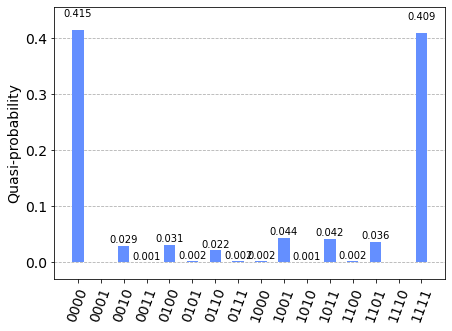

In [ ]:
# Plot best1 layout's result of sampler (resilience_level = 1)
plot_histogram(truncate(sampler_cv[0][0],state_labels))

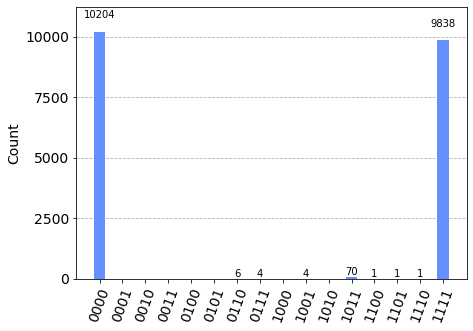

In [ ]:
# Plot best1 layout's result of our mitigation method
plot_histogram(sv_to_counts(avg_probs_list_local[0]))

In [ ]:
fid_non_list

[0.964809586875, 0.888220865625, 0.707273305, 0.5497997915625001]

In [ ]:
fid_list

[0.9986336780930621,
 0.9959893606219405,
 0.9759099236663644,
 0.9510367715667009]

In [ ]:
fid_list_local

[0.9997757402459778, 0.9984678254035363, 0.9915153649313461, 0.980540269373382]

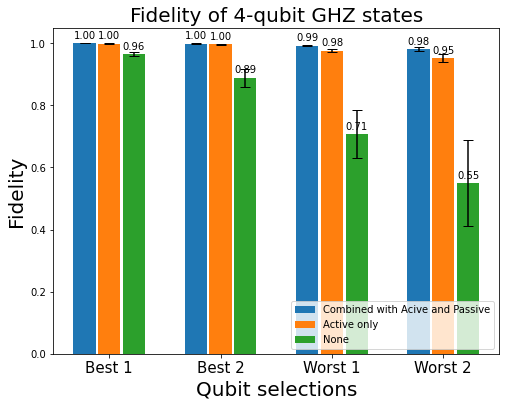

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

all_results = [fid_list_local,fid_list,fid_non_list]

x = np.arange(len(all_results[0]))
stds = [std_list_local, std_list, std_non_list]
bar_width = 0.2

fig, ax = plt.subplots(figsize=(8, 6))
labels = ['Combined with Acive and Passive','Active only','None']
for i, results in enumerate(all_results):
    x_shifted = x + (i - 1) * bar_width * 10/9
    ax.bar(x_shifted, results, bar_width, label=labels[i])
    ax.errorbar(x_shifted, results, yerr=stds[i], fmt='none', color='black', capsize=5)

    for j, result in enumerate(results):
            ax.annotate(f'{result:.2f}', xy=(x_shifted[j], result), xytext=(0, 3),
                        textcoords="offset points", ha='center', va='bottom')
ax.set_xticks(x)
ax.set_xticklabels(['Best 1', 'Best 2', 'Worst 1', 'Worst 2'], fontsize=15)

plt.xlabel('Qubit selections', fontsize = 20)
plt.ylabel('Fidelity', fontsize = 20)
plt.title('Fidelity of 4-qubit GHZ states', fontsize = 20)

ax.legend(loc='lower right')

plt.show()


In [219]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(instance = 'q-info-hackathon/team-6/main')
from qiskit_ibm_runtime import Sampler, Session, Options
options = Options(resilience_level = 1)
session = Session(service=service,backend=service.get_backend('ibm_canberra'))
sampler = Sampler(session=session, options = options)

In [220]:
sampler_jobs = sampler.run([tcb1,tcb2,tcw1,tcw2]*4, shots = 20000)
results = sampler_jobs.result()

### 2. Implement One-Hop Bidirectional Quantum Communication

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

c:\Users\c5517\python\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: eet is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
import qiskit
qiskit.__qiskit_version__
import sys
print(sys.version)

3.8.0 (tags/v3.8.0:fa919fd, Oct 14 2019, 19:37:50) [MSC v.1916 64 bit (AMD64)]


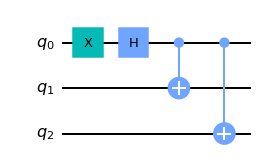

In [3]:
def GHZ(encode):
    qc = QuantumCircuit(3)
    encode = list(map(int, bin(encode)[2:].zfill(3)))
    if encode[0] == 1:
        qc.x(0)
    if encode[1] == 1:
        qc.x(1)
    if encode[2] == 1:
        qc.x(2)
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(0, 2)
        
    return qc

def ghz_dagger():
    qc = QuantumCircuit(3)
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.h(0)
    return qc

GHZ_DAGGER = ghz_dagger()
GHZ(4).draw("mpl")

In [4]:
postprocess_dict = [
    {0b110: ['x'], 0b001: ['z'], 0b111: ['x', 'z']},
    {0b000: ['x'], 0b001: ['x', 'z'], 0b111: ['z']},
    {0b010: ['x'], 0b101: ['z'], 0b011: ['x', 'z']},
    {0b100: ['x'], 0b101: ['x', 'z'], 0b011: ['z']},
    {0b110: ['x', 'z'], 0b000: ['z'], 0b111: ['x']},
    {0b110: ['z'], 0b000: ['x', 'z'], 0b001: ['x']},
    {0b010: ['x', 'z'], 0b100: ['z'], 0b011: ['x']},
    {0b010: ['z'], 0b100: ['x', 'z'], 0b101: ['x']}
    ]

In [5]:
class Leftnode:
    def __init__(self, x, q, encode = 0):
        self.data = x
        self.right = q
        self.rightencode = encode

class Rightnode:
    def __init__(self, q, x, encode = 0):
        self.data = x
        self.left = q
        self.leftencode = encode

class Internode:
    def __init__(self, left, right, encode = (0, 0)):
        self.left = left
        self.right = right
        self.leftencode, self.rightencode = encode

In [6]:
class Multinode:
    '''
        Generates a multi-node GHZ channel.
    '''
    def __init__(self, a, b, qlist, encodelist = None):
        '''
            Initialize multi-node GHZ channel, entangling qubits in qlist.
            a: int; index of Alice's custom qubit
            b: int; index of Bob's custom qubit
            qlist: list; list of tuples of two lists containing indices of qubits 
                         that will be entangled in GHZ states
                   input format:
                     [([a1, a2, a3], [c1, c2, c3]), ([c4, c5, c6], [b1, b2, b3])]
                   which results in
                     [a | a1, a2, c1] - [a3, c2, c3 | c4, c5, b1] - [c6, b2, b3 | b]
                   and so on.
            encodelist: int; determines the type of pre-prepared GHZ states among GHZ basis
                        input format:
                          [(a, c1), (c2, b), ...]
                        which results in
                          [a1, a2, c1]: encoded a
                          [a3, c2, c3]: encoded c1
                          ... and so on
        '''
        self.N = N = len(qlist)
        self.qr = QuantumRegister(6*N+2, name="q")
        self.cr = [ClassicalRegister(3, name="r" + str(i)) for i in range(2*N)] + [ClassicalRegister(2)]
        qc = QuantumCircuit(self.qr, *self.cr)
        if encodelist == None: encodelist = [(0, 0) for i in range(N)]
        
        self.alice = Leftnode(a, None, encodelist[0][0])
        self.bob = Rightnode(None, b, encodelist[-1][1])
        self.channel = [self.alice] + [Internode(None, None, (encodelist[i][1], encodelist[i+1][0])) for i in range(N - 1)] + [self.bob]
        for i, q in enumerate(qlist):
            ql, qr = q
            qc = qc.compose(GHZ(encodelist[i][0]), ql)
            qc = qc.compose(GHZ(encodelist[i][1]), qr[::-1])
            ql0, ql1, ql2 = ql
            qr0, qr1, qr2 = qr
            self.channel[i].right = [ql0, ql1, qr0]
            self.channel[i+1].left = [ql2, qr1, qr2]
        self.qc = qc
    def entangle(self):
        '''
            Entangles each node to transfer information.
            alicetrack, bobtrack: stores path to backpropagate for postprocessing.
        '''
        self.qc.barrier()
        qc = self.qc
        self.alicetrack = [([self.alice.data, self.alice.right[0], self.alice.right[1]], self.alice.rightencode)]
        qc = qc.compose(GHZ_DAGGER, [self.alice.data, self.alice.right[0], self.alice.right[1]])
        self.bobtrack = [([self.bob.data, self.bob.left[2], self.bob.left[1]], self.bob.leftencode)]
        qc = qc.compose(GHZ_DAGGER, [self.bob.data, self.bob.left[2], self.bob.left[1]])
        
        for channel in self.channel[1:-1]:
            qc = qc.compose(GHZ_DAGGER, [channel.left[0], channel.right[0], channel.right[1]])
            self.alicetrack.append(([channel.left[0], channel.right[0], channel.right[1]], channel.rightencode))
        
        for channel in self.channel[-2:0:-1]:
            qc = qc.compose(GHZ_DAGGER, [channel.right[2], channel.left[2], channel.left[1]])
            self.bobtrack.append(([channel.right[2], channel.left[2], channel.left[1]], channel.leftencode))
        
        self.qc = qc
    def measure(self):
        '''
            Measures the value of multi-hop channel on the classical register.
            Alice: (0, 1, 2), Bob: (6N-3, 6N-2, 6N-1),
            and other i-th intermediate channels in (3i, 3i+1, 3i+2)
        '''
        self.qc.barrier()
        qc = self.qc
        # Change the location of the "data holder" of Alice and Bob
        self.alice.data, self.alice.right = self.alice.right[2], [self.alice.data, self.alice.right[0], self.alice.right[1]]
        self.bob.data, self.bob.left = self.bob.left[0], [self.bob.data, self.bob.left[2], self.bob.left[1]]
        for i, alicetrack in enumerate(self.alicetrack):
            qc.measure(alicetrack[0], self.cr[i])
        for i, bobtrack in enumerate(self.bobtrack):
            qc.measure(bobtrack[0], self.cr[self.N + i])
            
    def postprocess(self, measure = False):
        '''
            Postprocess the resulting Alice and Bob's (new) qubit, by backpropagation.
            Postprocessing gate must vary depending on the value of 'encode'.
        '''
        self.qc.barrier()
        qc = self.qc
        for i, alicetrack in enumerate(self.alicetrack):
            encode = alicetrack[1]
            for possible_result in postprocess_dict[encode]:
                with qc.if_test((self.cr[self.N - i - 1], possible_result)): 
                    gate = postprocess_dict[encode][possible_result]
                    if 'x' in gate:
                        qc.x(self.bob.data)
                    if 'z' in gate:
                        qc.z(self.bob.data)
                
            
        for i, bobtrack in enumerate(self.bobtrack):
            encode = bobtrack[1]
            for possible_result in postprocess_dict[encode]:
                with qc.if_test((self.cr[2*self.N - i - 1], possible_result)):
                    gate = postprocess_dict[encode][possible_result]
                    if 'x' in gate:
                        qc.x(self.alice.data)
                    if 'z' in gate:
                        qc.z(self.alice.data)
        
        # measure result for evaluation
        if measure:
            qc.barrier()
            qc.measure([self.alice.data, self.bob.data], qc.clbits[-2:])
            self.qc = qc
        
    def __str__(self):
        '''
            Displays the qubits residing in each channel.
            Format: [Alice's qubit | Alice's three qubits] [Internal qubits | Internal qubits] [Bob's three qubits | Bob's qubit]
        '''
        s = "[" + str(self.alice.data) + "|" + ",".join(map(str,self.alice.right)) + "] "
        for channel in self.channel[1:-1]:
            s += "[" + ",".join(map(str,channel.left)) + "|" +",".join(map(str,channel.right)) + "] "
        s += "[" + ",".join(map(str,self.bob.left)) + "|" + str(self.bob.data) + "]"
        return s

[0|1,2,3] [4,5,6|7]


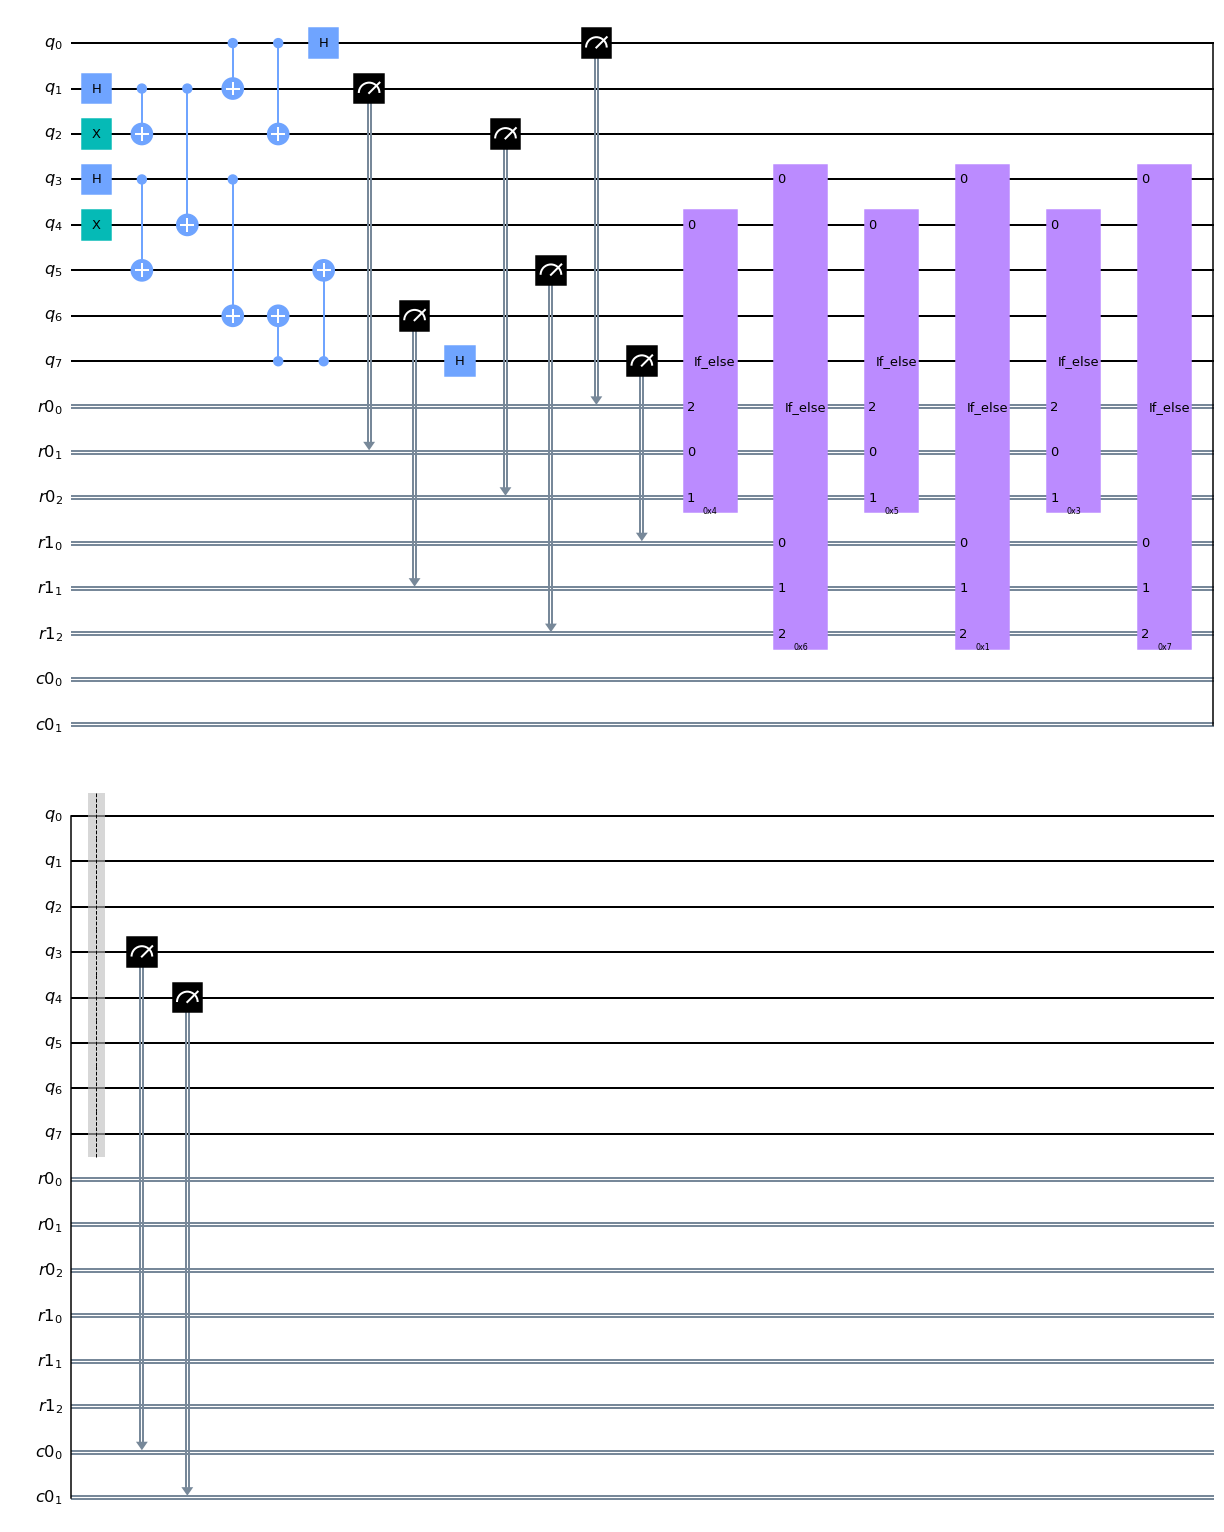

In [7]:
# qc.x(6*N + 1)
# Initialize multi-hop channel
#ch = Multinode(0, 19, [([1, 2, 4], [3, 5, 6]), ([7, 8, 10], [9, 11, 12]), ([13, 14, 16], [15, 17, 18])], [(2, 3), (4, 5), (1, 0)])
#ch = Multinode(0, 13, [([1, 2, 4], [3, 5, 6]), ([7, 8, 10], [9, 11, 12])])
ch = Multinode(0, 7, [([1, 2, 4], [3, 5, 6])], [(7, 7)])
print(ch)
ch.entangle()
ch.measure()
ch.postprocess(True)
# Concatenate and measure
ch.qc.draw("mpl", scale = 0.8)

In [9]:
from qiskit import transpile, Aer
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_counts

sim = AerSimulator()


qc0 = QuantumCircuit(8, 8)
qc0 = qc0.compose(ch.qc)
qc1 = QuantumCircuit(8, 8)
qc1.x(0)
qc1 = qc1.compose(ch.qc)
qc2 = QuantumCircuit(8, 8)
qc2.x(7)
qc2 = qc2.compose(ch.qc)
qc3 = QuantumCircuit(8, 8)
qc3.x(0)
qc3.x(7)
qc3 = qc3.compose(ch.qc)

### Result of One-Hop Bidirectional Quantum Communication

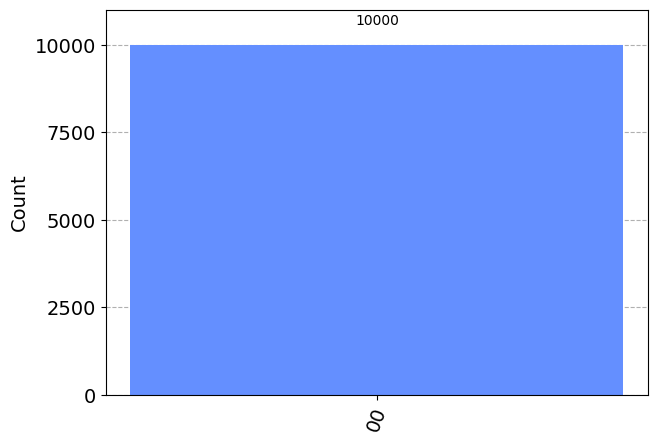

In [ ]:
# run job
shots = 10000
job = sim.run(qc0, shots=shots, dynamic = True)

# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts()
exp_counts = marginal_counts(exp_counts, [6, 7])

plot_histogram(exp_counts)

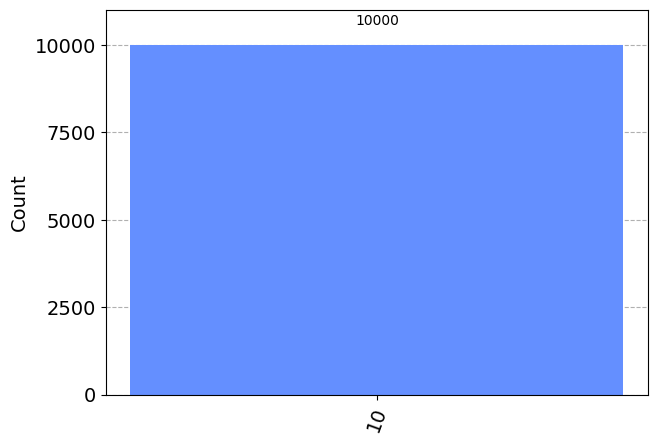

In [ ]:
# run job
shots = 10000
job = sim.run(qc1, shots=shots, dynamic = True)

# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts()
exp_counts = marginal_counts(exp_counts, [6, 7])

plot_histogram(exp_counts)

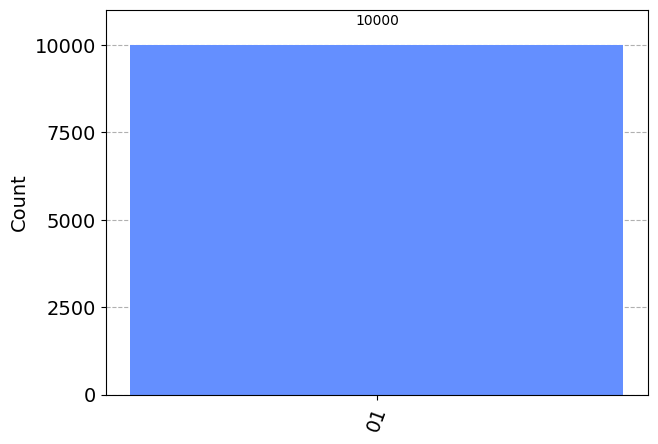

In [ ]:
# run job
shots = 10000
job = sim.run(qc2, shots=shots, dynamic = True)

# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts()
exp_counts = marginal_counts(exp_counts, [6, 7])

plot_histogram(exp_counts)

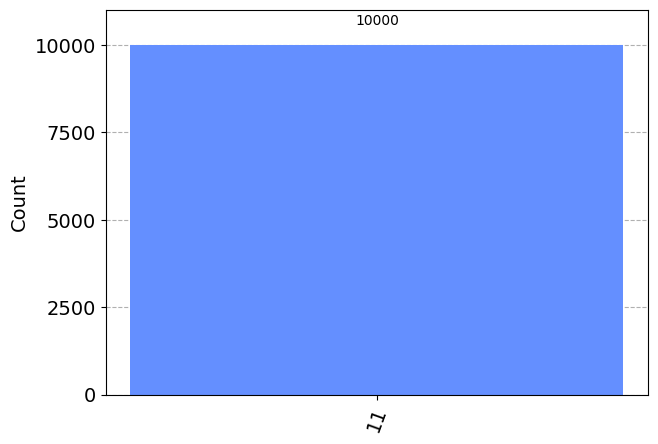

In [ ]:
# run job
shots = 10000
job = sim.run(qc3, shots=shots, dynamic = True)

# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts()
exp_counts = marginal_counts(exp_counts, [6, 7])

plot_histogram(exp_counts)

### Result of Multi-Hop Bidirectional Quantum Communication, arbitrary N

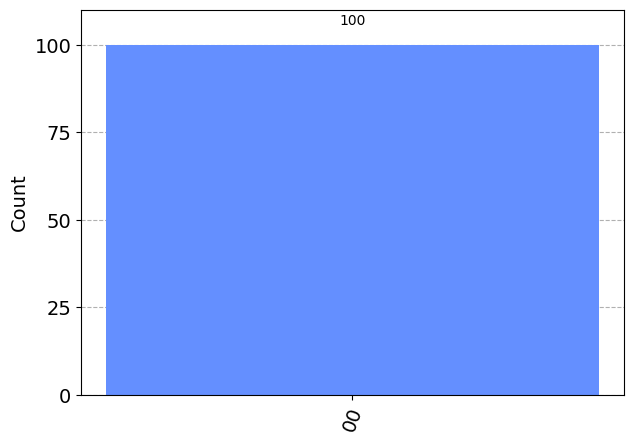

In [ ]:
# run job
shots = 100
job = sim.run(qc0, shots=shots, dynamic = True)

# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts()
exp_counts = marginal_counts(exp_counts, [6*N, 6*N+1])

plot_histogram(exp_counts)

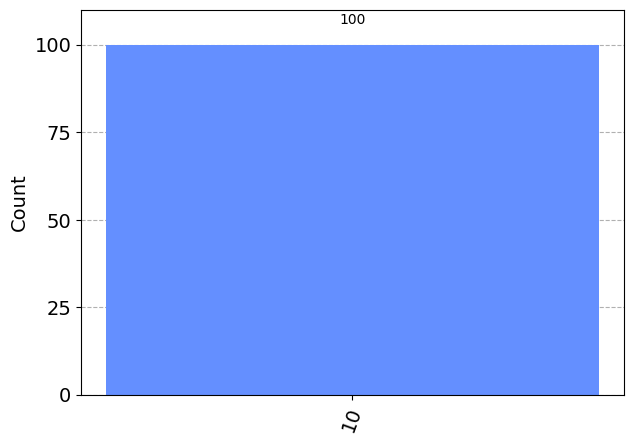

In [ ]:
# run job
shots = 100
job = sim.run(qc1, shots=shots, dynamic = True)

# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts()
exp_counts = marginal_counts(exp_counts, [6*N, 6*N+1])

plot_histogram(exp_counts)

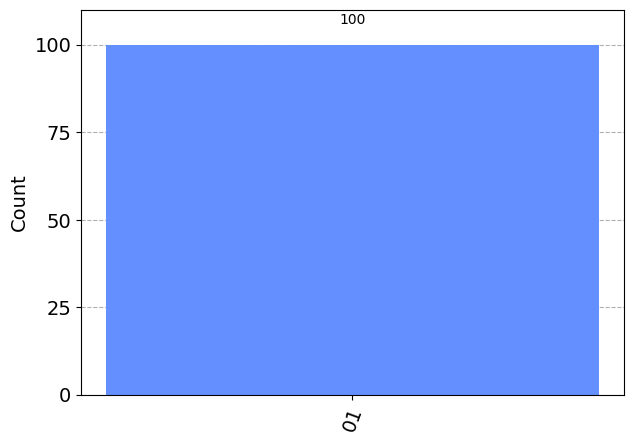

In [ ]:
# run job
shots = 100
job = sim.run(qc2, shots=shots, dynamic = True)

# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts()
exp_counts = marginal_counts(exp_counts, [6*N, 6*N+1])

plot_histogram(exp_counts)

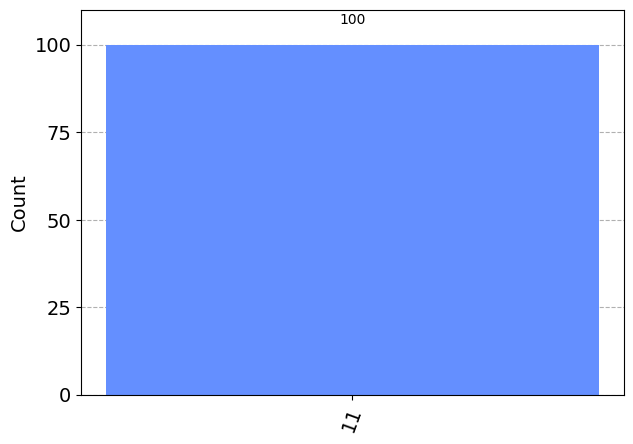

In [ ]:
# run job
shots = 100
job = sim.run(qc3, shots=shots, dynamic = True)

# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts()
exp_counts = marginal_counts(exp_counts, [6*N, 6*N+1])

plot_histogram(exp_counts)

We couldn't run this scheme on real hardware due to internal hardware which is not fixable at this very moment. But below is the cell for hardware run.

In [14]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()

hub = "q-info-hackathon"
group = "team-6"
project = "main"

backend_name = "ibm_canberra"
backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")

'''qc0 = QuantumCircuit(8, 8)
qc0 = qc0.compose(ch.qc)
tqc0 = transpile(qc0, backend, initial_layout = [3, 5, 8, 12, 11, 13, 15, 18], optimization_level = 1)

qc1 = QuantumCircuit(8, 8)
qc1.x(0)
qc1 = qc1.compose(ch.qc)
tqc1 = transpile(qc1, backend, initial_layout = [3, 5, 8, 12, 11, 13, 15, 18], optimization_level = 1)

qc2 = QuantumCircuit(8, 8)
qc2.x(7)
qc2 = qc2.compose(ch.qc)
tqc2 = transpile(qc2, backend, initial_layout = [3, 5, 8, 12, 11, 13, 15, 18], optimization_level = 1)

qc3 = QuantumCircuit(8, 8)
qc3.x(0)
qc3.x(7)
qc3 = qc3.compose(ch.qc)
tqc3 = transpile(qc3, backend, initial_layout = [3, 5, 8, 12, 11, 13, 15, 18], optimization_level = 1)'''


tqc = transpile(ch.qc, backend, optimization_level = 1) # we use optimization level 1, because currently if_else syntax is not
                                                                                                        # supported with optimization level 3
# tqc = transpile(ch.qc, backend, optimization_level = 1)
# job = backend.run(tqc, shots=20000, dynamic = True)
# job_id = job.job_id()
# print(job_id)

### Mapomatic : Post compilation routine to find best circuit layout
#### We cannot run this circuit on real hardware, but still it is important to find which layouts to use, especially when we are runing big circuits on real hardware

[0|1,2,3] [4,5,6|7]


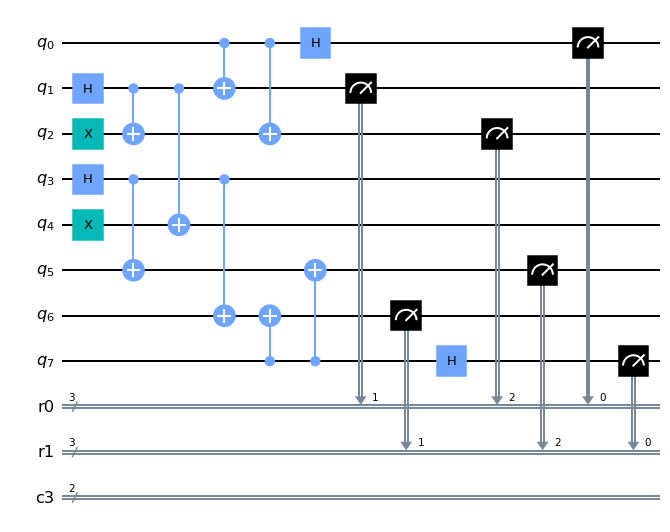

In [11]:
# Get rid of circuit barrier for compilation routine, get rid of if_else routine because it's not supported yet

from qiskit import transpile
ch2 = Multinode(0, 7, [([1, 2, 4], [3, 5, 6])], [(3, 0)])
print(ch2)
ch2.entangle()
ch2.measure()
# Concatenate and measure
tqc = transpile(ch2.qc, backend, optimization_level = 3)
ch2.qc.draw("mpl")

In [16]:
# import mapomatic and deflate the transpiled circuit and get layouts, score of each layouts, lower the better
import mapomatic as mm
deflated = mm.deflate_circuit(tqc)
layouts = mm.matching_layouts(deflated, backend)
scores = mm.evaluate_layouts(deflated, layouts, backend)
scores

[([2, 1, 0, 4, 12, 15, 17, 18], 0.2164911900532488),
 ([0, 1, 2, 4, 12, 15, 17, 18], 0.2164911900532489),
 ([22, 19, 20, 16, 12, 15, 17, 18], 0.22708023740835315),
 ([20, 19, 22, 16, 12, 15, 17, 18], 0.22708023740835326),
 ([22, 19, 20, 16, 3, 2, 0, 1], 0.23289658329839258),
 ([20, 19, 22, 16, 3, 2, 0, 1], 0.2328965832983927),
 ([2, 1, 0, 4, 25, 22, 20, 19], 0.2344397634035975),
 ([0, 1, 2, 4, 25, 22, 20, 19], 0.2344397634035975),
 ([0, 1, 2, 4, 9, 8, 3, 5], 0.2348689439658207),
 ([2, 1, 0, 4, 9, 8, 3, 5], 0.2348689439658208),
 ([22, 19, 20, 16, 0, 1, 3, 2], 0.23583977939077816),
 ([20, 19, 22, 16, 0, 1, 3, 2], 0.23583977939077816),
 ([2, 1, 0, 4, 11, 8, 3, 5], 0.23666468102829963),
 ([0, 1, 2, 4, 11, 8, 3, 5], 0.23666468102829963),
 ([2, 1, 0, 4, 8, 11, 13, 14], 0.23800588227264197),
 ([0, 1, 2, 4, 8, 11, 13, 14], 0.23800588227264197),
 ([22, 19, 20, 16, 5, 3, 1, 2], 0.23881046578315857),
 ([20, 19, 22, 16, 5, 3, 1, 2], 0.23881046578315868),
 ([5, 8, 9, 11, 12, 15, 17, 18], 0.23924563

In [23]:
# So we can choose below best layout when we run this circuit on real hardware
best_layout, worst_layout = scores[0], scores[-1]
best_layout, worst_layout # 24 qubit has cnot error 1.0 from calibration which is wrong calibration, which means it might not be the worst layout

(([2, 1, 0, 4, 12, 15, 17, 18], 0.2164911900532488),
 ([24, 25, 22, 26, 20, 19, 14, 16], 1.0))

We depend on the layouts from transpiled circuit, but transpiling differs every time we transpile due to the stochastic swap mapper <br>
Therefore, it would be nicer to get many transpiled circuits and get scores from each circuit and choose the best one <br>
Also, we can customize how to score the layouts depending on circuit or error mitigation scheme we use

In [28]:
tqc = transpile(ghz4_ac,backend, optimization_level = 3)
deflated = mm.deflate_circuit(tqc)
layouts = mm.matching_layouts(deflated, backend)
scores = mm.evaluate_layouts(deflated, layouts, backend)
scores

[([3, 5, 8, 9, 11, 13, 14], 0.22523411626257273),
 ([14, 13, 12, 10, 15, 17, 18], 0.23141956617009707),
 ([14, 11, 8, 9, 5, 2, 3], 0.23744011011944155),
 ([25, 22, 19, 20, 16, 13, 14], 0.2470383901307106),
 ([7, 10, 12, 13, 15, 17, 18], 0.24759531792400535),
 ([14, 16, 19, 20, 22, 26, 25], 0.24808703908864727),
 ([19, 16, 14, 13, 11, 9, 8], 0.2526831442791011),
 ([3, 5, 8, 9, 11, 16, 14], 0.2536823231936084),
 ([8, 11, 14, 13, 16, 20, 19], 0.2564668602383514),
 ([18, 15, 12, 13, 10, 6, 7], 0.2566367442718206),
 ([18, 15, 12, 10, 13, 11, 14], 0.2572704595831211),
 ([19, 16, 14, 13, 11, 5, 8], 0.25940574525168336),
 ([14, 13, 12, 15, 10, 6, 7], 0.2608334615020904),
 ([23, 21, 18, 17, 15, 13, 12], 0.2613884004893392),
 ([18, 15, 12, 10, 13, 16, 14], 0.2623993937047784),
 ([12, 13, 14, 16, 11, 9, 8], 0.2653944871510493),
 ([14, 13, 12, 10, 15, 21, 18], 0.265521361245348),
 ([23, 21, 18, 17, 15, 10, 12], 0.2655414843123729),
 ([8, 11, 14, 16, 13, 15, 12], 0.26575491922647587),
 ([8, 11, 14,

In [ ]:
# Recap, We choose below qubit sets considering qubit properties, which almost match with mapomatic's suggestion
best1 = [3,5,8,11, 2, 9, 14]
best2 = [13,12,15,18, 14,10,17]
worst1 = [23,24,25,22, 21, 26, 19]
worst2 = [15,18,21,23, 12,17,24]

In [32]:
scores[0], scores[1]

(([3, 5, 8, 9, 11, 13, 14], 0.22523411626257273),
 ([14, 13, 12, 10, 15, 17, 18], 0.23141956617009707))

In [35]:
scores[-5], scores[-2]

(([12, 15, 18, 17, 21, 24, 23], 1.0), ([23, 24, 25, 26, 22, 20, 19], 1.0))